# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Libraries

In [1]:
import numpy as np
from numpy.linalg import inv
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


## Camera Calibration

### Load images and store corners

In [2]:
vertical_tiles = 6
horizontal_tiles = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((vertical_tiles*horizontal_tiles, 3), np.float32)
objp[:,:2] = np.mgrid[0:horizontal_tiles, 0:vertical_tiles].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (horizontal_tiles, vertical_tiles), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

### Undistort function
**PS**: This function will now work if cell above is not ran previously

In [3]:
def undistort(img):
    global objpoints, imgpoints
    
    img_size = (img.shape[1], img.shape[0])
    
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)

### Test function to undistort

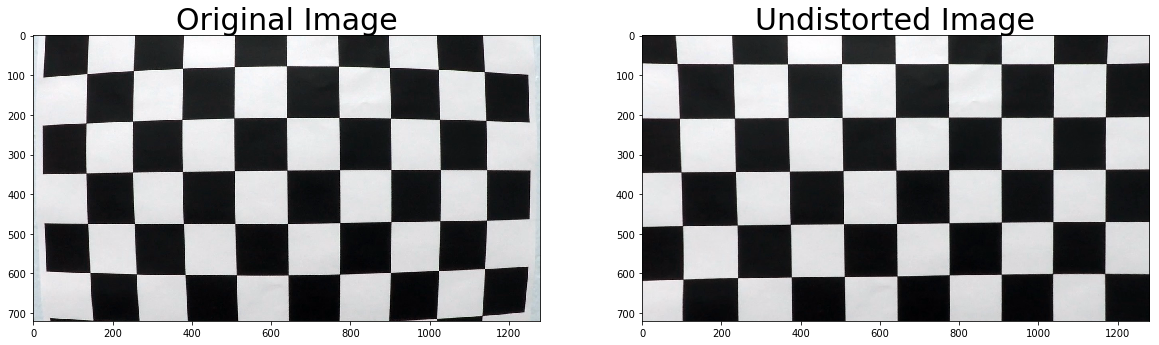

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')

dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Set Color Scheme To Detect Line

In [5]:
def threshold_image(image, channel, thresh = (0, 255), ft='RGB'):
    assert channel >=0 and channel <=2
    
    if ft == 'HLS':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if ft == 'HSV':
        img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if ft == 'RGB':
        img = image
        
    s_channel = img[:,:,channel]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary

In [ ]:
image = mpimg.imread('test_images/test5.jpg')
# image = warped

image_HSV_V = threshold_image(image, channel=2, thresh=(220,255), ft='HSV')

plt.imshow(image_HSV_V, cmap='gray')

In [ ]:
image_HLS_S = threshold_image(image, channel=2, thresh=(90,255), ft='HLS')

plt.imshow(image_HLS_S, cmap='gray')

### Combine Color Images

In [ ]:
combined_color = np.zeros_like(image_HSV_V)

combined_color[((image_HSV_V == 1) & (image_HLS_S == 1))] = 1

plt.imshow(combined_color, cmap='gray')

## Set Gradient Scheme

In [6]:
''' Returns the directional gradient given an angle threshold '''

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


''' Returns an image with the combine magnitude of gradients X & Y bounded by a threshold '''

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


''' Returns an image with the gradient accordingly to one direction bounded by a threshold '''

def single_axis_threshold(image, axis, sobel_kernel=3, thresh=(0,255)):
    assert axis == 'x' or axis == 'y'
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    elif axis == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
        
    abs_sobel = np.absolute(sobel)    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

In [ ]:
image_example = mpimg.imread('test_images/test5.jpg')
# image_example = warped

image_axis_x = single_axis_threshold(image_example, axis='x', sobel_kernel=5,thresh=(30,80))

plt.imshow(image_axis_x, cmap='gray')

In [ ]:
image_axis_y = single_axis_threshold(image_example, axis='y', sobel_kernel=3,thresh=(30,80))

plt.imshow(image_axis_y, cmap='gray')

In [ ]:
image_mag = mag_threshold(image_example, sobel_kernel=3,thresh=(30,100))

plt.imshow(image_mag, cmap='gray')

In [ ]:
image_dir = dir_threshold(image_example, sobel_kernel=3, thresh=(0.7, 1.3))

plt.imshow(image_dir, cmap='gray')

### Combine Gradient Images

In [ ]:
combined_grad = np.zeros_like(image_axis_x)

combined_grad[((image_axis_x == 1) )#& (image_axis_y == 1)) 
              | ((image_mag == 1) & (image_dir == 1))] = 1

plt.imshow(combined_grad, cmap='gray')

## Combine Colors and Gradient

In [ ]:
combined_all = np.zeros_like(combined_grad)

combined_all[((combined_color == 1) | (combined_grad == 1))] = 1

plt.imshow(combined_all, cmap='gray')

## Line Detection Function
---
Let's now encapsulate everything that was done so far into a single function.

In [7]:
def binary_image(image):
    # Apply color filters
    image_HSV_V = threshold_image(image, channel=2, thresh=(220,255), ft='HSV')
    image_HLS_S = threshold_image(image, channel=2, thresh=(90,255), ft='HLS')
    # Combine color images
    combined_color = np.zeros_like(image_HSV_V)
    combined_color[((image_HSV_V == 1) & (image_HLS_S == 1))] = 1
    
    # Apply Gradient filters
    image_axis_x = single_axis_threshold(image, axis='x', sobel_kernel=5,thresh=(30,80))
    image_axis_y = single_axis_threshold(image, axis='y', sobel_kernel=3,thresh=(40,80))
    image_mag = mag_threshold(image, sobel_kernel=3,thresh=(30,100))
    image_dir = dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3))
    # Combine Gradient images
    combined_grad = np.zeros_like(image_axis_x)
    combined_grad[((image_axis_x == 1) )#& (image_axis_y == 1)) 
              | ((image_mag == 1) & (image_dir == 1))] = 1

    # Combine color and gradient
    combined_all = np.zeros_like(combined_grad)
    combined_all[((combined_color == 1) | (combined_grad == 1))] = 1
    
    return combined_all

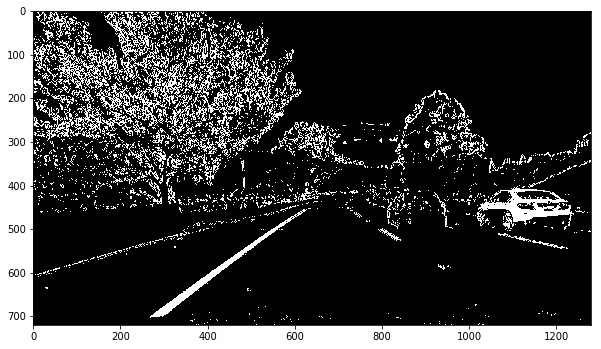

In [8]:
image = mpimg.imread('test_images/test6.jpg')
image = undistort(image)

detection = binary_image(image)

plt.imshow(detection, cmap='gray')

## Bird View
---
Pipeline able to change the perspective of the image with the objective of creating a "bird view".

In order to perform the warping it is necessary to identify points 4 points of the road in the original image (corners of the red polygon) and where they will be warpped to (corners of the green polygon).

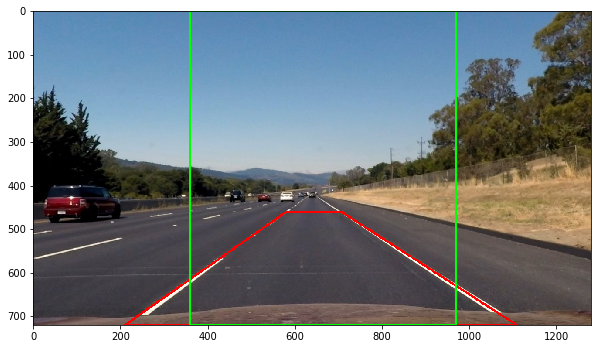

In [9]:
image = mpimg.imread('test_images/straight_lines2.jpg')
image = undistort(image)
warp_template = np.copy(image)

top_left = (580,460)
top_right = (707,460)
bottom_left = (210,720)
bottom_right = (1110,720)

src = np.float32([[bottom_left, top_left, top_right, bottom_right]])

left_bound, right_bound = (360, 970)

top_left = (left_bound,0)
top_right = (right_bound,0)
bottom_left = (left_bound,720)
bottom_right = (right_bound,720)

dst = np.float32([[bottom_left, top_left, top_right, bottom_right]])

road_trapezoid = np.array(src, np.int32)
road_square = np.array(dst, np.int32)

cv2.polylines(warp_template,[road_trapezoid],True,(255,0,0), thickness = 3)
cv2.polylines(warp_template,[road_square],True,(0,255,0), thickness = 3)

plt.imshow(warp_template)

### Generate a warped image

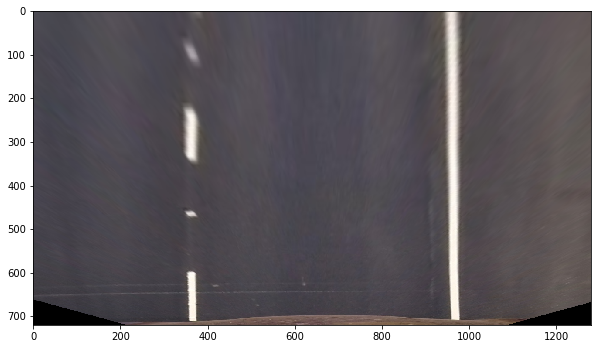

In [10]:
img_x, img_y, chn = image.shape

M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(image, M, (img_y, img_x))

plt.imshow(warped)

### Function to warp images
---
Time to put the warping process inside a function.

In [11]:
''' 
    This function takes an images and returns a bird-view perspective 
    of it with the transformation matrix used 
'''

def bird_eye(image):
    top_left = (580,460)
    top_right = (707,460)
    bottom_left = (210,720)
    bottom_right = (1110,720)
    src = np.float32([[bottom_left, top_left, top_right, bottom_right]])

    left_bound, right_bound = (360, 970)
    top_left = (left_bound,0)
    top_right = (right_bound,0)
    bottom_left = (left_bound,720)
    bottom_right = (right_bound,720)
    dst = np.float32([[bottom_left, top_left, top_right, bottom_right]])

    img_x, img_y, chn = image.shape

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (img_y, img_x))
    return M,warped

### The pipeline so far ...

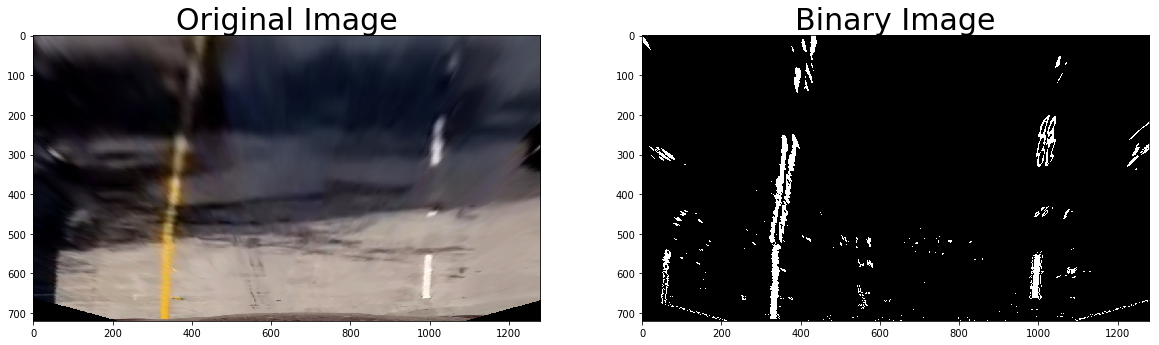

In [12]:
image = mpimg.imread('test_images/test5.jpg')
image = undistort(image)

M, warped = bird_eye(image)

binary = binary_image(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)

### Image histogram
---
The peaks will tell us where the lines are.

In [ ]:
import numpy as np
histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Line Detection Functions

In [13]:
''' 
The sliding window function breaks the lines in many spices in order to fit a polynomial
that will follow the line
'''

def sliding_window_polyfit(binary, nwindows=9, margin=100, minpix=50, plot=False):
    if plot:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary, binary, binary))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    # Left Peak X position
    leftx_base = np.argmax(histogram[:midpoint])
    # Right Peak X position
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plot:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, left_fitx, right_fit, right_fitx, ploty


'''
Once you already have a polynomial function is not necessary to use the sliding windows
anymore, instead a function that updates the polinommial with the new image should be enough
'''

def update_polyfit(binary, left_fit, right_fit):
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, left_fitx, right_fit, right_fitx, ploty


'''
Compute the vehicle curvature having the polynomial for each line
'''

def curvatures(y_eval, left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad


pixe2meters = {'y':30/720, 'x':3.7/700}


def curvature(y_eval, fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = pixe2meters['y'] # meters per pixel in y dimension
    xm_per_pix = pixe2meters['x'] # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curve_meters = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    return curve_meters

''' Compute the distance from the lane to the center of the vehicle '''

vehicle_center = (640, 719)

def distance_center(fitx):
    return (fitx[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']

Running the sliding window:
* Red: Left Line
* Blue: Right Line
* Yellow: polynomial aproximation
* Green: windows

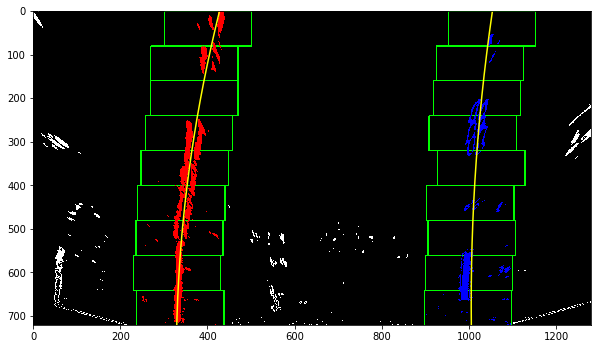

In [14]:
left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=True)

Calculate the curvature of the turn in meters

In [15]:
curvature(720, left_fitx, ploty), curvature(720, right_fitx, ploty) 

(1057.3017091263598, 1508.9271852778438)

Calculate the distance between the lane and the center of the vehicle in meters

In [16]:
distance_center(left_fitx), distance_center(right_fitx)

(-1.6401600583064322, 1.9309733518681873)

### Function to Draw on Image
---
This function will draw on image and warpit back to the original shape.

In [17]:
def back_to_original(undist, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

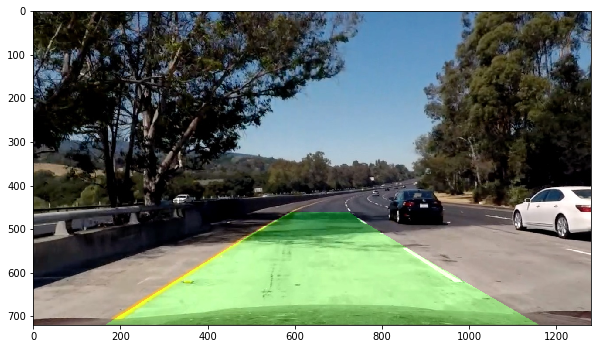

In [18]:
marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)

plt.imshow(marked_image)

## Line Detection Pipeline
---
Create a function that aplies all that was showed so far and return a marked image.

In [19]:
def pipeline(raw_image):
    # 1 - Undistort Image
    image = undistort(raw_image)
    # 2 - Warp Image
    M, warped = bird_eye(image)
    # 3 - Binnary Warped Image
    binary = binary_image(warped)    
    # 4 - Apply Sliding Window
    left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
    # 5 - Draw Road on the Original Image
    marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)
    return marked_image

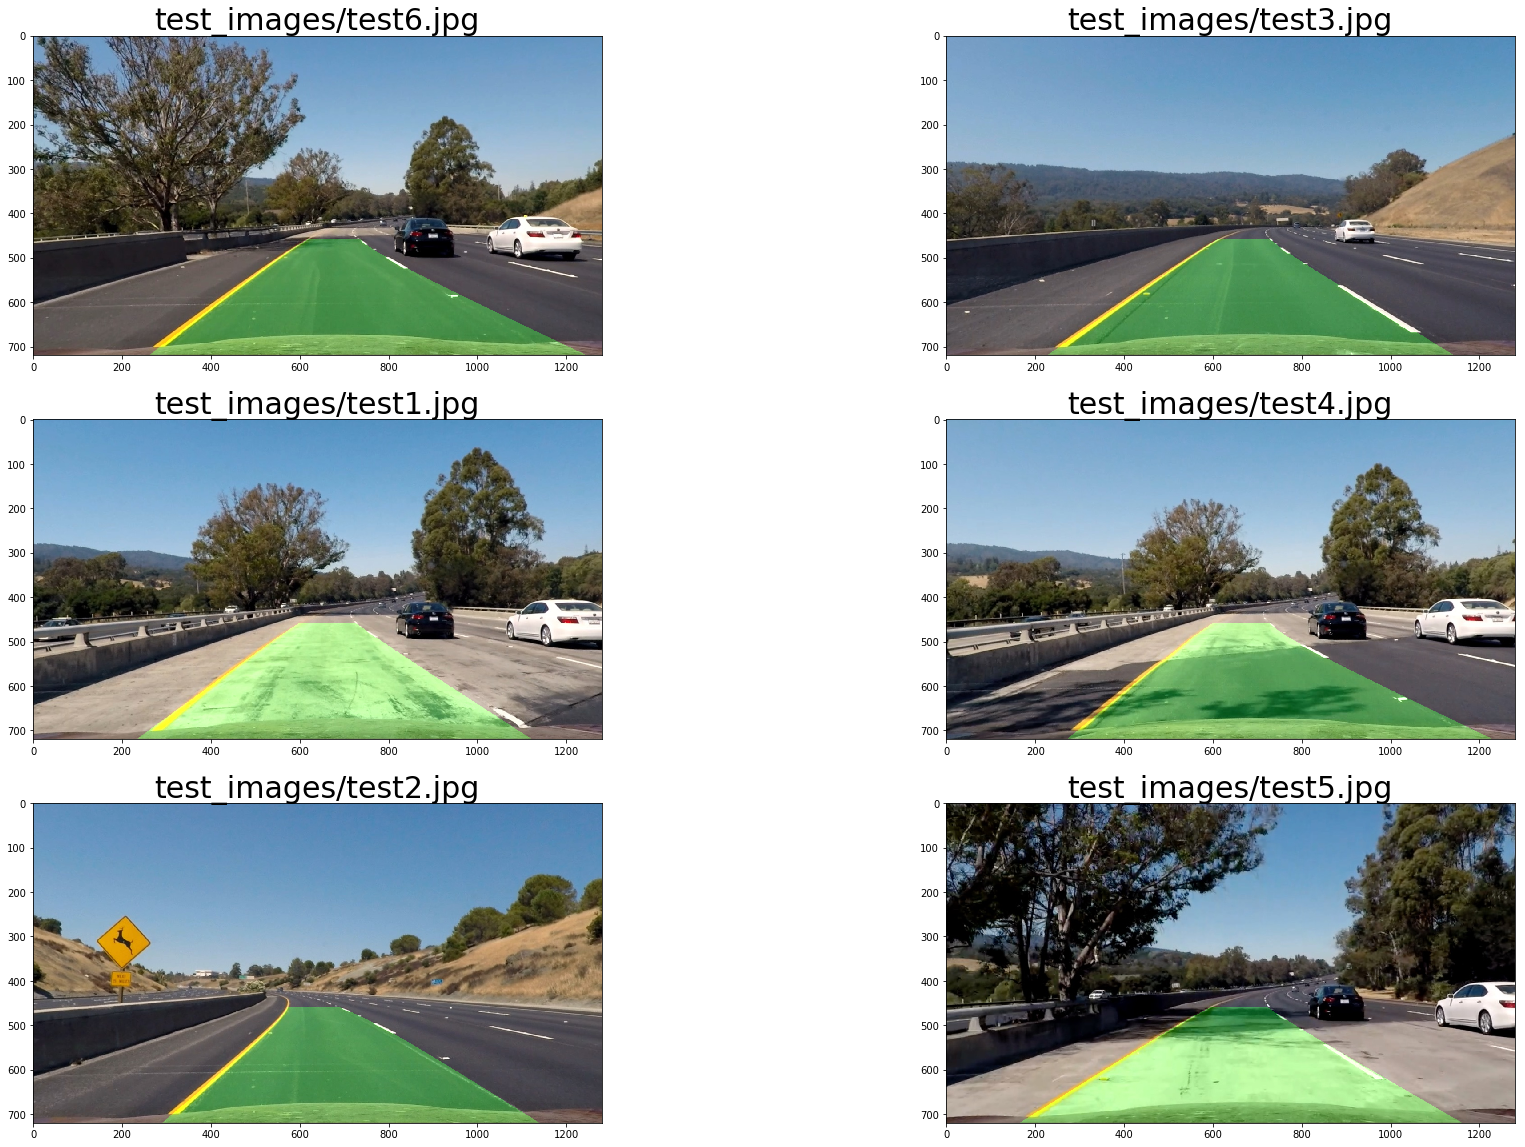

In [20]:
images = glob.glob('test_images/test*.jpg')

n_images = len(images)

f, plots = plt.subplots(int(ceil(n_images/2)), 2, figsize=(30,20))
plots = plots.flatten()

for i, img in enumerate(images):
    image = mpimg.imread(img)
    out = pipeline(image)
    plots[i].imshow(out)
    plots[i].set_title(img, fontsize=30)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
white_output = 'out_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip1 = VideoFileClip("project_video.mp4").subclip(0,5)

# clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video out_test.mp4
[MoviePy] Writing video out_test.mp4


 99%|█████████▉| 125/126 [01:25<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test.mp4 

CPU times: user 1min 31s, sys: 14 s, total: 1min 45s
Wall time: 1min 25s


## Class Line
---
This class will assist detect the line in a video. It will help to define when to use the sliding window methodod or just expand on the existing line polygon.

In [54]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [106]:
# Number of fits to average on
N = 10
count_before_reset = 0
reset_threshold = 5

curvature_tolerance = 1000
x_dist_tolerance = (3.6, 3.8)

def sanity_check(left_line, right_line):
    print("Curve =", left_line.radius_of_curvature, right_line.radius_of_curvature, abs(left_line.radius_of_curvature - right_line.radius_of_curvature))
    print("Center =", abs(left_line.line_base_pos), abs(right_line.line_base_pos))
    
    if abs(left_line.radius_of_curvature - right_line.radius_of_curvature) > curvature_tolerance:
        return False
    elif not(x_dist_tolerance[0] <= (abs(left_line.line_base_pos) + abs(right_line.line_base_pos)) <= x_dist_tolerance[1]):
        return False
    # Not sure on how to know if they are paralel should I compare the coeficients?
    else:
        return True


def drawing(image, binary, M, left_line, right_line, ploty):
    drawed = back_to_original(image, binary, inv(M), left_line.bestx, right_line.bestx, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius Curvature = {}(m)'.format(round(left_line.radius_of_curvature,2))
    cv2.putText(drawed,text,(10,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = 'Left curve to center = {}(m)'.format(round(left_line.line_base_pos,2))
    cv2.putText(drawed,text,(10,100), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    text = 'Distance to Center: Right Curve {}(m)'.format(round(right_line.line_base_pos, 2))
    cv2.putText(drawed,text,(10,150), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    return drawed


def reset(binary):
    print('\nRESETTING\n')
    # Apply Sliding Window
    left_fit, left_fitx, right_fit, right_fitx, ploty = sliding_window_polyfit(binary, plot=False)   
    
    left_line = Line()
    left_line.detected = True
    left_line.recent_xfitted = left_fitx
    left_line.bestx = left_fitx
    left_line.best_fit = left_fit
    left_line.current_fit = left_fit
    left_line.radius_of_curvature = curvature(vehicle_center[1], left_fitx, ploty)
    left_line.line_base_pos = distance_center(left_fitx)
    left_line.allx = [left_fitx]
    left_line.ally = [ploty]
    
    right_line = Line()
    right_line.detected = True
    right_line.recent_xfitted = right_fitx
    right_line.bestx = right_fitx
    right_line.best_fit = right_fit
    right_line.current_fit = right_fit
    right_line.radius_of_curvature = curvature(vehicle_center[1], right_fitx, ploty)
    right_line.line_base_pos = distance_center(right_fitx)
    right_line.allx = [right_fitx]
    right_line.ally = [ploty]
    
    count_before_reset = 0
    
    return left_line, right_line, ploty

scoop = None

def smoothing(line, ploty):
    global N, scoop
    # Get the points from the past N frames
    
    pastx = np.concatenate(line.allx[-N:])
    pasty = np.concatenate(line.ally[-N:])
    
    # Get new averaged fit
    line.best_fit = np.polyfit(np.concatenate([pasty, ploty]), np.concatenate([pastx, line.recent_xfitted]), 2)

    # Get best X
    line.bestx = line.best_fit[0]*ploty**2 + line.best_fit[1]*ploty + line.best_fit[2]
    
    line.allx.append(line.bestx)
    line.ally.append(ploty)


def handle_good_lines(left_line, right_line, ploty):
    # Update Line Fields
    # was the line detected in the last iteration?
    left_line.detected = True
    right_line.detected = True
    
    # Average N fits
    smoothing(left_line, ploty)
    smoothing(right_line, ploty)
    
    return left_line, right_line, ploty


def handle_bad_lines(left_line, right_line, ploty):
    return left_line, right_line, ploty
        

def look_ahead(binary, left_line, right_line):
    global count_before_reset, reset_threshold
    
    print("\n@@ LOOK AHEAD\n")
    
    # Update the polyfit with new warped binary image
    left_fit, left_fitx, right_fit, right_fitx, ploty = update_polyfit(binary, left_line.best_fit, right_line.best_fit)
    
    # Update current fit/pts
    left_line.current_fit = left_fit
    left_line.recent_xfitted = left_fitx
    
    right_line.current_fit = right_fit
    right_line.recent_xfitted = right_fitx    
        
    # Update curvature
    left_line.radius_of_curvature = curvature(vehicle_center[1], left_fitx, ploty)
    right_line.radius_of_curvature = curvature(vehicle_center[1], right_fitx, ploty)
    
    # Update distance to center of the vehicle
    left_line.line_base_pos = (left_fitx[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']
    right_line.line_base_pos = (right_fitx[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']
    
    check = sanity_check(left_line, right_line)
    print("Sanity:", check)
    
    # Check if a good line was detected
    if check:
        return handle_good_lines(left_line, right_line, ploty)
    else:
        # Test if should reset
        count_before_reset += 1
        if(count_before_reset == reset_threshold):
            return reset(binary)
        else:
            return handle_bad_lines(left_line, right_line, ploty)

In [107]:
n_frames = 0
left_line, right_line, ploty = (None, None, None)


def final_pipeline(raw_image):
    global n_frames, left_line, right_line, ploty
    # 1 - Undistort Image
    image = undistort(raw_image)
    # 2 - Warp Image
    M, warped = bird_eye(image)
    # 3 - Binnary Warped Image
    binary = binary_image(warped)    

    left_line, right_line, ploty = reset(binary)
    
#     if(n_frames == 0):
#         left_line, right_line, ploty = reset(binary)
#     else:
#         left_line, right_line, ploty = look_ahead(binary, left_line, right_line)
        
#     n_frames += 1
    
    marked_image = drawing(image, binary, M, left_line, right_line, ploty)
    
    return marked_image
    
    

In [108]:
white_output = 'output_final1.mp4'
n_frames = 0
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

# clip1 = VideoFileClip("project_video.mp4").subclip(24,27)

# clip1 = VideoFileClip("project_video.mp4").subclip(0,3)

clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)


RESETTING

[MoviePy] >>>> Building video output_final1.mp4
[MoviePy] Writing video output_final1.mp4


  0%|          | 1/1261 [00:00<14:29,  1.45it/s]


RESETTING



  0%|          | 2/1261 [00:01<14:44,  1.42it/s]


RESETTING



  0%|          | 3/1261 [00:02<14:37,  1.43it/s]


RESETTING



  0%|          | 4/1261 [00:02<14:33,  1.44it/s]


RESETTING



  0%|          | 5/1261 [00:03<14:26,  1.45it/s]


RESETTING



  0%|          | 6/1261 [00:04<14:21,  1.46it/s]


RESETTING



  1%|          | 7/1261 [00:04<14:17,  1.46it/s]


RESETTING



  1%|          | 8/1261 [00:05<14:23,  1.45it/s]


RESETTING



  1%|          | 9/1261 [00:06<14:29,  1.44it/s]


RESETTING



  1%|          | 10/1261 [00:06<14:40,  1.42it/s]


RESETTING



  1%|          | 11/1261 [00:07<14:34,  1.43it/s]


RESETTING



  1%|          | 12/1261 [00:08<14:25,  1.44it/s]


RESETTING



  1%|          | 13/1261 [00:09<14:19,  1.45it/s]


RESETTING



  1%|          | 14/1261 [00:09<14:15,  1.46it/s]


RESETTING



  1%|          | 15/1261 [00:10<14:14,  1.46it/s]


RESETTING



  1%|▏         | 16/1261 [00:11<14:10,  1.46it/s]


RESETTING



  1%|▏         | 17/1261 [00:11<14:08,  1.47it/s]


RESETTING



  1%|▏         | 18/1261 [00:12<14:09,  1.46it/s]


RESETTING



  2%|▏         | 19/1261 [00:13<14:09,  1.46it/s]


RESETTING



  2%|▏         | 20/1261 [00:13<14:06,  1.47it/s]


RESETTING



  2%|▏         | 21/1261 [00:14<14:05,  1.47it/s]


RESETTING



  2%|▏         | 22/1261 [00:15<14:04,  1.47it/s]


RESETTING



  2%|▏         | 23/1261 [00:15<14:02,  1.47it/s]


RESETTING



  2%|▏         | 24/1261 [00:16<14:01,  1.47it/s]


RESETTING



  2%|▏         | 25/1261 [00:17<14:01,  1.47it/s]


RESETTING



  2%|▏         | 26/1261 [00:17<13:59,  1.47it/s]


RESETTING



  2%|▏         | 27/1261 [00:18<13:58,  1.47it/s]


RESETTING



  2%|▏         | 28/1261 [00:19<13:57,  1.47it/s]


RESETTING



  2%|▏         | 29/1261 [00:19<13:56,  1.47it/s]


RESETTING



  2%|▏         | 30/1261 [00:20<13:54,  1.47it/s]


RESETTING



  2%|▏         | 31/1261 [00:21<13:55,  1.47it/s]


RESETTING



  3%|▎         | 32/1261 [00:21<13:54,  1.47it/s]


RESETTING



  3%|▎         | 33/1261 [00:22<13:54,  1.47it/s]


RESETTING



  3%|▎         | 34/1261 [00:23<13:54,  1.47it/s]


RESETTING



  3%|▎         | 35/1261 [00:23<13:51,  1.47it/s]


RESETTING



  3%|▎         | 36/1261 [00:24<13:50,  1.48it/s]


RESETTING



  3%|▎         | 37/1261 [00:25<13:48,  1.48it/s]


RESETTING



  3%|▎         | 38/1261 [00:25<13:48,  1.48it/s]


RESETTING



  3%|▎         | 39/1261 [00:26<13:47,  1.48it/s]


RESETTING



  3%|▎         | 40/1261 [00:27<13:46,  1.48it/s]


RESETTING



  3%|▎         | 41/1261 [00:28<13:46,  1.48it/s]


RESETTING



  3%|▎         | 42/1261 [00:28<13:46,  1.47it/s]


RESETTING



  3%|▎         | 43/1261 [00:29<13:49,  1.47it/s]


RESETTING



  3%|▎         | 44/1261 [00:30<13:48,  1.47it/s]


RESETTING



  4%|▎         | 45/1261 [00:30<13:46,  1.47it/s]


RESETTING



  4%|▎         | 46/1261 [00:31<13:47,  1.47it/s]


RESETTING



  4%|▎         | 47/1261 [00:32<13:44,  1.47it/s]


RESETTING



  4%|▍         | 48/1261 [00:32<13:44,  1.47it/s]


RESETTING



  4%|▍         | 49/1261 [00:33<13:44,  1.47it/s]


RESETTING



  4%|▍         | 50/1261 [00:34<13:44,  1.47it/s]


RESETTING



  4%|▍         | 51/1261 [00:34<13:44,  1.47it/s]


RESETTING



  4%|▍         | 52/1261 [00:35<13:46,  1.46it/s]


RESETTING



  4%|▍         | 53/1261 [00:36<13:47,  1.46it/s]


RESETTING



  4%|▍         | 54/1261 [00:36<13:45,  1.46it/s]


RESETTING



  4%|▍         | 55/1261 [00:37<13:42,  1.47it/s]


RESETTING



  4%|▍         | 56/1261 [00:38<13:42,  1.47it/s]


RESETTING



  5%|▍         | 57/1261 [00:38<13:42,  1.46it/s]


RESETTING



  5%|▍         | 58/1261 [00:39<13:43,  1.46it/s]


RESETTING



  5%|▍         | 59/1261 [00:40<13:41,  1.46it/s]


RESETTING



  5%|▍         | 60/1261 [00:41<13:42,  1.46it/s]


RESETTING



  5%|▍         | 61/1261 [00:41<13:40,  1.46it/s]


RESETTING



  5%|▍         | 62/1261 [00:42<13:38,  1.46it/s]


RESETTING



  5%|▍         | 63/1261 [00:43<13:41,  1.46it/s]


RESETTING



  5%|▌         | 64/1261 [00:43<13:39,  1.46it/s]


RESETTING



  5%|▌         | 65/1261 [00:44<13:36,  1.46it/s]


RESETTING



  5%|▌         | 66/1261 [00:45<13:34,  1.47it/s]


RESETTING



  5%|▌         | 67/1261 [00:45<13:32,  1.47it/s]


RESETTING



  5%|▌         | 68/1261 [00:46<13:31,  1.47it/s]


RESETTING



  5%|▌         | 69/1261 [00:47<13:30,  1.47it/s]


RESETTING



  6%|▌         | 70/1261 [00:47<13:28,  1.47it/s]


RESETTING



  6%|▌         | 71/1261 [00:48<13:27,  1.47it/s]


RESETTING



  6%|▌         | 72/1261 [00:49<13:28,  1.47it/s]


RESETTING



  6%|▌         | 73/1261 [00:49<13:29,  1.47it/s]


RESETTING



  6%|▌         | 74/1261 [00:50<13:30,  1.47it/s]


RESETTING



  6%|▌         | 75/1261 [00:51<13:27,  1.47it/s]


RESETTING



  6%|▌         | 76/1261 [00:51<13:25,  1.47it/s]


RESETTING



  6%|▌         | 77/1261 [00:52<13:24,  1.47it/s]


RESETTING



  6%|▌         | 78/1261 [00:53<13:23,  1.47it/s]


RESETTING



  6%|▋         | 79/1261 [00:53<13:22,  1.47it/s]


RESETTING



  6%|▋         | 80/1261 [00:54<13:21,  1.47it/s]


RESETTING



  6%|▋         | 81/1261 [00:55<13:21,  1.47it/s]


RESETTING



  7%|▋         | 82/1261 [00:55<13:21,  1.47it/s]


RESETTING



  7%|▋         | 83/1261 [00:56<13:23,  1.47it/s]


RESETTING



  7%|▋         | 84/1261 [00:57<13:22,  1.47it/s]


RESETTING



  7%|▋         | 85/1261 [00:58<13:23,  1.46it/s]


RESETTING



  7%|▋         | 86/1261 [00:58<13:23,  1.46it/s]


RESETTING



  7%|▋         | 87/1261 [00:59<13:21,  1.46it/s]


RESETTING



  7%|▋         | 88/1261 [01:00<13:19,  1.47it/s]


RESETTING



  7%|▋         | 89/1261 [01:00<13:23,  1.46it/s]


RESETTING



  7%|▋         | 90/1261 [01:01<13:23,  1.46it/s]


RESETTING



  7%|▋         | 91/1261 [01:02<13:22,  1.46it/s]


RESETTING



  7%|▋         | 92/1261 [01:02<13:19,  1.46it/s]


RESETTING



  7%|▋         | 93/1261 [01:03<13:16,  1.47it/s]


RESETTING



  7%|▋         | 94/1261 [01:04<13:14,  1.47it/s]


RESETTING



  8%|▊         | 95/1261 [01:04<13:12,  1.47it/s]


RESETTING



  8%|▊         | 96/1261 [01:05<13:13,  1.47it/s]


RESETTING



  8%|▊         | 97/1261 [01:06<13:10,  1.47it/s]


RESETTING



  8%|▊         | 98/1261 [01:06<13:08,  1.48it/s]


RESETTING



  8%|▊         | 99/1261 [01:07<13:07,  1.48it/s]


RESETTING



  8%|▊         | 100/1261 [01:08<13:08,  1.47it/s]


RESETTING



  8%|▊         | 101/1261 [01:08<13:08,  1.47it/s]


RESETTING



  8%|▊         | 102/1261 [01:09<13:11,  1.47it/s]


RESETTING



  8%|▊         | 103/1261 [01:10<13:08,  1.47it/s]


RESETTING



  8%|▊         | 104/1261 [01:10<13:08,  1.47it/s]


RESETTING



  8%|▊         | 105/1261 [01:11<13:06,  1.47it/s]


RESETTING



  8%|▊         | 106/1261 [01:12<13:04,  1.47it/s]


RESETTING



  8%|▊         | 107/1261 [01:13<13:03,  1.47it/s]


RESETTING



  9%|▊         | 108/1261 [01:13<13:04,  1.47it/s]


RESETTING



  9%|▊         | 109/1261 [01:14<13:03,  1.47it/s]


RESETTING



  9%|▊         | 110/1261 [01:15<13:04,  1.47it/s]


RESETTING



  9%|▉         | 111/1261 [01:15<13:04,  1.47it/s]


RESETTING



  9%|▉         | 112/1261 [01:16<13:04,  1.46it/s]


RESETTING



  9%|▉         | 113/1261 [01:17<13:03,  1.46it/s]


RESETTING



  9%|▉         | 114/1261 [01:17<13:04,  1.46it/s]


RESETTING



  9%|▉         | 115/1261 [01:18<13:02,  1.46it/s]


RESETTING



  9%|▉         | 116/1261 [01:19<13:01,  1.46it/s]


RESETTING



  9%|▉         | 117/1261 [01:19<13:02,  1.46it/s]


RESETTING



  9%|▉         | 118/1261 [01:20<13:01,  1.46it/s]


RESETTING



  9%|▉         | 119/1261 [01:21<12:59,  1.47it/s]


RESETTING



 10%|▉         | 120/1261 [01:21<12:57,  1.47it/s]


RESETTING



 10%|▉         | 121/1261 [01:22<12:59,  1.46it/s]


RESETTING



 10%|▉         | 122/1261 [01:23<12:57,  1.46it/s]


RESETTING



 10%|▉         | 123/1261 [01:23<12:57,  1.46it/s]


RESETTING



 10%|▉         | 124/1261 [01:24<12:58,  1.46it/s]


RESETTING



 10%|▉         | 125/1261 [01:25<12:56,  1.46it/s]


RESETTING



 10%|▉         | 126/1261 [01:25<12:55,  1.46it/s]


RESETTING



 10%|█         | 127/1261 [01:26<12:52,  1.47it/s]


RESETTING



 10%|█         | 128/1261 [01:27<12:50,  1.47it/s]


RESETTING



 10%|█         | 129/1261 [01:28<12:51,  1.47it/s]


RESETTING



 10%|█         | 130/1261 [01:28<12:53,  1.46it/s]


RESETTING



 10%|█         | 131/1261 [01:29<13:01,  1.45it/s]


RESETTING



 10%|█         | 132/1261 [01:30<12:59,  1.45it/s]


RESETTING



 11%|█         | 133/1261 [01:30<12:57,  1.45it/s]


RESETTING



 11%|█         | 134/1261 [01:31<12:56,  1.45it/s]


RESETTING



 11%|█         | 135/1261 [01:32<12:54,  1.45it/s]


RESETTING



 11%|█         | 136/1261 [01:32<12:53,  1.45it/s]


RESETTING



 11%|█         | 137/1261 [01:33<12:50,  1.46it/s]


RESETTING



 11%|█         | 138/1261 [01:34<12:47,  1.46it/s]


RESETTING



 11%|█         | 139/1261 [01:34<12:45,  1.47it/s]


RESETTING



 11%|█         | 140/1261 [01:35<12:43,  1.47it/s]


RESETTING



 11%|█         | 141/1261 [01:36<12:45,  1.46it/s]


RESETTING



 11%|█▏        | 142/1261 [01:36<12:43,  1.47it/s]


RESETTING



 11%|█▏        | 143/1261 [01:37<12:42,  1.47it/s]


RESETTING



 11%|█▏        | 144/1261 [01:38<12:40,  1.47it/s]


RESETTING



 11%|█▏        | 145/1261 [01:38<12:40,  1.47it/s]


RESETTING



 12%|█▏        | 146/1261 [01:39<12:40,  1.47it/s]


RESETTING



 12%|█▏        | 147/1261 [01:40<12:39,  1.47it/s]


RESETTING



 12%|█▏        | 148/1261 [01:41<12:38,  1.47it/s]


RESETTING



 12%|█▏        | 149/1261 [01:41<12:38,  1.47it/s]


RESETTING



 12%|█▏        | 150/1261 [01:42<12:39,  1.46it/s]


RESETTING



 12%|█▏        | 151/1261 [01:43<12:38,  1.46it/s]


RESETTING



 12%|█▏        | 152/1261 [01:43<12:36,  1.47it/s]


RESETTING



 12%|█▏        | 153/1261 [01:44<12:35,  1.47it/s]


RESETTING



 12%|█▏        | 154/1261 [01:45<12:36,  1.46it/s]


RESETTING



 12%|█▏        | 155/1261 [01:45<12:37,  1.46it/s]


RESETTING



 12%|█▏        | 156/1261 [01:46<12:35,  1.46it/s]


RESETTING



 12%|█▏        | 157/1261 [01:47<12:33,  1.47it/s]


RESETTING



 13%|█▎        | 158/1261 [01:47<12:30,  1.47it/s]


RESETTING



 13%|█▎        | 159/1261 [01:48<12:29,  1.47it/s]


RESETTING



 13%|█▎        | 160/1261 [01:49<12:29,  1.47it/s]


RESETTING



 13%|█▎        | 161/1261 [01:49<12:29,  1.47it/s]


RESETTING



 13%|█▎        | 162/1261 [01:50<12:27,  1.47it/s]


RESETTING



 13%|█▎        | 163/1261 [01:51<12:26,  1.47it/s]


RESETTING



 13%|█▎        | 164/1261 [01:51<12:24,  1.47it/s]


RESETTING



 13%|█▎        | 165/1261 [01:52<12:25,  1.47it/s]


RESETTING



 13%|█▎        | 166/1261 [01:53<12:26,  1.47it/s]


RESETTING



 13%|█▎        | 167/1261 [01:53<12:24,  1.47it/s]


RESETTING



 13%|█▎        | 168/1261 [01:54<12:26,  1.46it/s]


RESETTING



 13%|█▎        | 169/1261 [01:55<12:26,  1.46it/s]


RESETTING



 13%|█▎        | 170/1261 [01:56<12:26,  1.46it/s]


RESETTING



 14%|█▎        | 171/1261 [01:56<12:24,  1.46it/s]


RESETTING



 14%|█▎        | 172/1261 [01:57<12:25,  1.46it/s]


RESETTING



 14%|█▎        | 173/1261 [01:58<12:22,  1.46it/s]


RESETTING



 14%|█▍        | 174/1261 [01:58<12:20,  1.47it/s]


RESETTING



 14%|█▍        | 175/1261 [01:59<12:23,  1.46it/s]


RESETTING



 14%|█▍        | 176/1261 [02:00<12:23,  1.46it/s]


RESETTING



 14%|█▍        | 177/1261 [02:00<12:22,  1.46it/s]


RESETTING



 14%|█▍        | 178/1261 [02:01<12:22,  1.46it/s]


RESETTING



 14%|█▍        | 179/1261 [02:02<12:20,  1.46it/s]


RESETTING



 14%|█▍        | 180/1261 [02:02<12:16,  1.47it/s]


RESETTING



 14%|█▍        | 181/1261 [02:03<12:20,  1.46it/s]


RESETTING



 14%|█▍        | 182/1261 [02:04<12:17,  1.46it/s]


RESETTING



 15%|█▍        | 183/1261 [02:04<12:18,  1.46it/s]


RESETTING



 15%|█▍        | 184/1261 [02:05<12:14,  1.47it/s]


RESETTING



 15%|█▍        | 185/1261 [02:06<12:14,  1.46it/s]


RESETTING



 15%|█▍        | 186/1261 [02:06<12:15,  1.46it/s]


RESETTING



 15%|█▍        | 187/1261 [02:07<12:17,  1.46it/s]


RESETTING



 15%|█▍        | 188/1261 [02:08<12:13,  1.46it/s]


RESETTING



 15%|█▍        | 189/1261 [02:09<12:11,  1.47it/s]


RESETTING



 15%|█▌        | 190/1261 [02:09<12:10,  1.47it/s]


RESETTING



 15%|█▌        | 191/1261 [02:10<12:09,  1.47it/s]


RESETTING



 15%|█▌        | 192/1261 [02:11<12:07,  1.47it/s]


RESETTING



 15%|█▌        | 193/1261 [02:11<12:09,  1.46it/s]


RESETTING



 15%|█▌        | 194/1261 [02:12<12:08,  1.46it/s]


RESETTING



 15%|█▌        | 195/1261 [02:13<12:07,  1.47it/s]


RESETTING



 16%|█▌        | 196/1261 [02:13<12:12,  1.45it/s]


RESETTING



 16%|█▌        | 197/1261 [02:14<12:12,  1.45it/s]


RESETTING



 16%|█▌        | 198/1261 [02:15<12:10,  1.46it/s]


RESETTING



 16%|█▌        | 199/1261 [02:15<12:08,  1.46it/s]


RESETTING



 16%|█▌        | 200/1261 [02:16<12:07,  1.46it/s]


RESETTING



 16%|█▌        | 201/1261 [02:17<12:04,  1.46it/s]


RESETTING



 16%|█▌        | 202/1261 [02:17<12:05,  1.46it/s]


RESETTING



 16%|█▌        | 203/1261 [02:18<12:04,  1.46it/s]


RESETTING



 16%|█▌        | 204/1261 [02:19<12:03,  1.46it/s]


RESETTING



 16%|█▋        | 205/1261 [02:19<12:05,  1.46it/s]


RESETTING



 16%|█▋        | 206/1261 [02:20<12:02,  1.46it/s]


RESETTING



 16%|█▋        | 207/1261 [02:21<11:59,  1.46it/s]


RESETTING



 16%|█▋        | 208/1261 [02:22<11:57,  1.47it/s]


RESETTING



 17%|█▋        | 209/1261 [02:22<11:57,  1.47it/s]


RESETTING



 17%|█▋        | 210/1261 [02:23<11:55,  1.47it/s]


RESETTING



 17%|█▋        | 211/1261 [02:24<11:54,  1.47it/s]


RESETTING



 17%|█▋        | 212/1261 [02:24<11:53,  1.47it/s]


RESETTING



 17%|█▋        | 213/1261 [02:25<11:53,  1.47it/s]


RESETTING



 17%|█▋        | 214/1261 [02:26<11:52,  1.47it/s]


RESETTING



 17%|█▋        | 215/1261 [02:26<11:53,  1.47it/s]


RESETTING



 17%|█▋        | 216/1261 [02:27<11:55,  1.46it/s]


RESETTING



 17%|█▋        | 217/1261 [02:28<11:54,  1.46it/s]


RESETTING



 17%|█▋        | 218/1261 [02:28<11:51,  1.47it/s]


RESETTING



 17%|█▋        | 219/1261 [02:29<11:49,  1.47it/s]


RESETTING



 17%|█▋        | 220/1261 [02:30<11:47,  1.47it/s]


RESETTING



 18%|█▊        | 221/1261 [02:30<11:46,  1.47it/s]


RESETTING



 18%|█▊        | 222/1261 [02:31<11:45,  1.47it/s]


RESETTING



 18%|█▊        | 223/1261 [02:32<11:45,  1.47it/s]


RESETTING



 18%|█▊        | 224/1261 [02:32<11:45,  1.47it/s]


RESETTING



 18%|█▊        | 225/1261 [02:33<11:47,  1.46it/s]


RESETTING



 18%|█▊        | 226/1261 [02:34<11:48,  1.46it/s]


RESETTING



 18%|█▊        | 227/1261 [02:34<11:48,  1.46it/s]


RESETTING



 18%|█▊        | 228/1261 [02:35<11:47,  1.46it/s]


RESETTING



 18%|█▊        | 229/1261 [02:36<11:48,  1.46it/s]


RESETTING



 18%|█▊        | 230/1261 [02:37<11:45,  1.46it/s]


RESETTING



 18%|█▊        | 231/1261 [02:37<11:45,  1.46it/s]


RESETTING



 18%|█▊        | 232/1261 [02:38<11:44,  1.46it/s]


RESETTING



 18%|█▊        | 233/1261 [02:39<11:45,  1.46it/s]


RESETTING



 19%|█▊        | 234/1261 [02:39<11:41,  1.46it/s]


RESETTING



 19%|█▊        | 235/1261 [02:40<11:42,  1.46it/s]


RESETTING



 19%|█▊        | 236/1261 [02:41<11:42,  1.46it/s]


RESETTING



 19%|█▉        | 237/1261 [02:41<11:42,  1.46it/s]


RESETTING



 19%|█▉        | 238/1261 [02:42<11:39,  1.46it/s]


RESETTING



 19%|█▉        | 239/1261 [02:43<11:40,  1.46it/s]


RESETTING



 19%|█▉        | 240/1261 [02:43<11:39,  1.46it/s]


RESETTING



 19%|█▉        | 241/1261 [02:44<11:40,  1.46it/s]


RESETTING



 19%|█▉        | 242/1261 [02:45<11:39,  1.46it/s]


RESETTING



 19%|█▉        | 243/1261 [02:45<11:36,  1.46it/s]


RESETTING



 19%|█▉        | 244/1261 [02:46<11:33,  1.47it/s]


RESETTING



 19%|█▉        | 245/1261 [02:47<11:34,  1.46it/s]


RESETTING



 20%|█▉        | 246/1261 [02:48<11:35,  1.46it/s]


RESETTING



 20%|█▉        | 247/1261 [02:48<11:33,  1.46it/s]


RESETTING



 20%|█▉        | 248/1261 [02:49<11:30,  1.47it/s]


RESETTING



 20%|█▉        | 249/1261 [02:50<11:29,  1.47it/s]


RESETTING



 20%|█▉        | 250/1261 [02:50<11:27,  1.47it/s]


RESETTING



 20%|█▉        | 251/1261 [02:51<11:28,  1.47it/s]


RESETTING



 20%|█▉        | 252/1261 [02:52<11:28,  1.47it/s]


RESETTING



 20%|██        | 253/1261 [02:52<11:26,  1.47it/s]


RESETTING



 20%|██        | 254/1261 [02:53<11:28,  1.46it/s]


RESETTING



 20%|██        | 255/1261 [02:54<11:28,  1.46it/s]


RESETTING



 20%|██        | 256/1261 [02:54<11:27,  1.46it/s]


RESETTING



 20%|██        | 257/1261 [02:55<11:27,  1.46it/s]


RESETTING



 20%|██        | 258/1261 [02:56<11:26,  1.46it/s]


RESETTING



 21%|██        | 259/1261 [02:56<11:27,  1.46it/s]


RESETTING



 21%|██        | 260/1261 [02:57<11:24,  1.46it/s]


RESETTING



 21%|██        | 261/1261 [02:58<11:22,  1.46it/s]


RESETTING



 21%|██        | 262/1261 [02:58<11:20,  1.47it/s]


RESETTING



 21%|██        | 263/1261 [02:59<11:22,  1.46it/s]


RESETTING



 21%|██        | 264/1261 [03:00<11:22,  1.46it/s]


RESETTING



 21%|██        | 265/1261 [03:00<11:21,  1.46it/s]


RESETTING



 21%|██        | 266/1261 [03:01<11:18,  1.47it/s]


RESETTING



 21%|██        | 267/1261 [03:02<11:20,  1.46it/s]


RESETTING



 21%|██▏       | 268/1261 [03:03<11:18,  1.46it/s]


RESETTING



 21%|██▏       | 269/1261 [03:03<11:18,  1.46it/s]


RESETTING



 21%|██▏       | 270/1261 [03:04<11:18,  1.46it/s]


RESETTING



 21%|██▏       | 271/1261 [03:05<11:16,  1.46it/s]


RESETTING



 22%|██▏       | 272/1261 [03:05<11:14,  1.47it/s]


RESETTING



 22%|██▏       | 273/1261 [03:06<11:13,  1.47it/s]


RESETTING



 22%|██▏       | 274/1261 [03:07<11:12,  1.47it/s]


RESETTING



 22%|██▏       | 275/1261 [03:07<11:13,  1.46it/s]


RESETTING



 22%|██▏       | 276/1261 [03:08<11:11,  1.47it/s]


RESETTING



 22%|██▏       | 277/1261 [03:09<11:09,  1.47it/s]


RESETTING



 22%|██▏       | 278/1261 [03:09<11:07,  1.47it/s]


RESETTING



 22%|██▏       | 279/1261 [03:10<11:06,  1.47it/s]


RESETTING



 22%|██▏       | 280/1261 [03:11<11:05,  1.47it/s]


RESETTING



 22%|██▏       | 281/1261 [03:11<11:04,  1.47it/s]


RESETTING



 22%|██▏       | 282/1261 [03:12<11:04,  1.47it/s]


RESETTING



 22%|██▏       | 283/1261 [03:13<11:05,  1.47it/s]


RESETTING



 23%|██▎       | 284/1261 [03:13<11:06,  1.47it/s]


RESETTING



 23%|██▎       | 285/1261 [03:14<11:06,  1.46it/s]


RESETTING



 23%|██▎       | 286/1261 [03:15<11:05,  1.47it/s]


RESETTING



 23%|██▎       | 287/1261 [03:15<11:04,  1.47it/s]


RESETTING



 23%|██▎       | 288/1261 [03:16<11:03,  1.47it/s]


RESETTING



 23%|██▎       | 289/1261 [03:17<11:02,  1.47it/s]


RESETTING



 23%|██▎       | 290/1261 [03:18<11:01,  1.47it/s]


RESETTING



 23%|██▎       | 291/1261 [03:18<11:01,  1.47it/s]


RESETTING



 23%|██▎       | 292/1261 [03:19<10:58,  1.47it/s]


RESETTING



 23%|██▎       | 293/1261 [03:20<10:58,  1.47it/s]


RESETTING



 23%|██▎       | 294/1261 [03:20<11:00,  1.46it/s]


RESETTING



 23%|██▎       | 295/1261 [03:21<11:01,  1.46it/s]


RESETTING



 23%|██▎       | 296/1261 [03:22<10:59,  1.46it/s]


RESETTING



 24%|██▎       | 297/1261 [03:22<10:59,  1.46it/s]


RESETTING



 24%|██▎       | 298/1261 [03:23<10:57,  1.46it/s]


RESETTING



 24%|██▎       | 299/1261 [03:24<10:55,  1.47it/s]


RESETTING



 24%|██▍       | 300/1261 [03:24<10:55,  1.47it/s]


RESETTING



 24%|██▍       | 301/1261 [03:25<10:55,  1.46it/s]


RESETTING



 24%|██▍       | 302/1261 [03:26<10:56,  1.46it/s]


RESETTING



 24%|██▍       | 303/1261 [03:26<10:54,  1.46it/s]


RESETTING



 24%|██▍       | 304/1261 [03:27<10:54,  1.46it/s]


RESETTING



 24%|██▍       | 305/1261 [03:28<10:52,  1.47it/s]


RESETTING



 24%|██▍       | 306/1261 [03:28<10:54,  1.46it/s]


RESETTING



 24%|██▍       | 307/1261 [03:29<10:54,  1.46it/s]


RESETTING



 24%|██▍       | 308/1261 [03:30<10:51,  1.46it/s]


RESETTING



 25%|██▍       | 309/1261 [03:30<10:51,  1.46it/s]


RESETTING



 25%|██▍       | 310/1261 [03:31<10:52,  1.46it/s]


RESETTING



 25%|██▍       | 311/1261 [03:32<10:49,  1.46it/s]


RESETTING



 25%|██▍       | 312/1261 [03:33<10:47,  1.47it/s]


RESETTING



 25%|██▍       | 313/1261 [03:33<10:45,  1.47it/s]


RESETTING



 25%|██▍       | 314/1261 [03:34<10:43,  1.47it/s]


RESETTING



 25%|██▍       | 315/1261 [03:35<10:43,  1.47it/s]


RESETTING



 25%|██▌       | 316/1261 [03:35<10:44,  1.47it/s]


RESETTING



 25%|██▌       | 317/1261 [03:36<10:42,  1.47it/s]


RESETTING



 25%|██▌       | 318/1261 [03:37<10:42,  1.47it/s]


RESETTING



 25%|██▌       | 319/1261 [03:37<10:42,  1.47it/s]


RESETTING



 25%|██▌       | 320/1261 [03:38<10:40,  1.47it/s]


RESETTING



 25%|██▌       | 321/1261 [03:39<10:43,  1.46it/s]


RESETTING



 26%|██▌       | 322/1261 [03:39<10:40,  1.47it/s]


RESETTING



 26%|██▌       | 323/1261 [03:40<10:39,  1.47it/s]


RESETTING



 26%|██▌       | 324/1261 [03:41<10:40,  1.46it/s]


RESETTING



 26%|██▌       | 325/1261 [03:41<10:37,  1.47it/s]


RESETTING



 26%|██▌       | 326/1261 [03:42<10:36,  1.47it/s]


RESETTING



 26%|██▌       | 327/1261 [03:43<10:36,  1.47it/s]


RESETTING



 26%|██▌       | 328/1261 [03:43<10:37,  1.46it/s]


RESETTING



 26%|██▌       | 329/1261 [03:44<10:35,  1.47it/s]


RESETTING



 26%|██▌       | 330/1261 [03:45<10:33,  1.47it/s]


RESETTING



 26%|██▌       | 331/1261 [03:46<10:35,  1.46it/s]


RESETTING



 26%|██▋       | 332/1261 [03:46<10:33,  1.47it/s]


RESETTING



 26%|██▋       | 333/1261 [03:47<10:32,  1.47it/s]


RESETTING



 26%|██▋       | 334/1261 [03:48<10:31,  1.47it/s]


RESETTING



 27%|██▋       | 335/1261 [03:48<10:31,  1.47it/s]


RESETTING



 27%|██▋       | 336/1261 [03:49<10:30,  1.47it/s]


RESETTING



 27%|██▋       | 337/1261 [03:50<10:29,  1.47it/s]


RESETTING



 27%|██▋       | 338/1261 [03:50<10:29,  1.47it/s]


RESETTING



 27%|██▋       | 339/1261 [03:51<10:27,  1.47it/s]


RESETTING



 27%|██▋       | 340/1261 [03:52<10:26,  1.47it/s]


RESETTING



 27%|██▋       | 341/1261 [03:52<10:25,  1.47it/s]


RESETTING



 27%|██▋       | 342/1261 [03:53<10:23,  1.47it/s]


RESETTING



 27%|██▋       | 343/1261 [03:54<10:23,  1.47it/s]


RESETTING



 27%|██▋       | 344/1261 [03:54<10:23,  1.47it/s]


RESETTING



 27%|██▋       | 345/1261 [03:55<10:21,  1.47it/s]


RESETTING



 27%|██▋       | 346/1261 [03:56<10:20,  1.47it/s]


RESETTING



 28%|██▊       | 347/1261 [03:56<10:21,  1.47it/s]


RESETTING



 28%|██▊       | 348/1261 [03:57<10:22,  1.47it/s]


RESETTING



 28%|██▊       | 349/1261 [03:58<10:22,  1.46it/s]


RESETTING



 28%|██▊       | 350/1261 [03:58<10:20,  1.47it/s]


RESETTING



 28%|██▊       | 351/1261 [03:59<10:21,  1.46it/s]


RESETTING



 28%|██▊       | 352/1261 [04:00<10:21,  1.46it/s]


RESETTING



 28%|██▊       | 353/1261 [04:00<10:18,  1.47it/s]


RESETTING



 28%|██▊       | 354/1261 [04:01<10:19,  1.46it/s]


RESETTING



 28%|██▊       | 355/1261 [04:02<10:17,  1.47it/s]


RESETTING



 28%|██▊       | 356/1261 [04:03<10:16,  1.47it/s]


RESETTING



 28%|██▊       | 357/1261 [04:03<10:15,  1.47it/s]


RESETTING



 28%|██▊       | 358/1261 [04:04<10:15,  1.47it/s]


RESETTING



 28%|██▊       | 359/1261 [04:05<10:15,  1.47it/s]


RESETTING



 29%|██▊       | 360/1261 [04:05<10:16,  1.46it/s]


RESETTING



 29%|██▊       | 361/1261 [04:06<10:15,  1.46it/s]


RESETTING



 29%|██▊       | 362/1261 [04:07<10:15,  1.46it/s]


RESETTING



 29%|██▉       | 363/1261 [04:07<10:17,  1.46it/s]


RESETTING



 29%|██▉       | 364/1261 [04:08<10:14,  1.46it/s]


RESETTING



 29%|██▉       | 365/1261 [04:09<10:13,  1.46it/s]


RESETTING



 29%|██▉       | 366/1261 [04:09<10:11,  1.46it/s]


RESETTING



 29%|██▉       | 367/1261 [04:10<10:09,  1.47it/s]


RESETTING



 29%|██▉       | 368/1261 [04:11<10:08,  1.47it/s]


RESETTING



 29%|██▉       | 369/1261 [04:11<10:08,  1.47it/s]


RESETTING



 29%|██▉       | 370/1261 [04:12<10:06,  1.47it/s]


RESETTING



 29%|██▉       | 371/1261 [04:13<10:05,  1.47it/s]


RESETTING



 30%|██▉       | 372/1261 [04:13<10:07,  1.46it/s]


RESETTING



 30%|██▉       | 373/1261 [04:14<10:04,  1.47it/s]


RESETTING



 30%|██▉       | 374/1261 [04:15<10:03,  1.47it/s]


RESETTING



 30%|██▉       | 375/1261 [04:15<10:03,  1.47it/s]


RESETTING



 30%|██▉       | 376/1261 [04:16<10:02,  1.47it/s]


RESETTING



 30%|██▉       | 377/1261 [04:17<10:01,  1.47it/s]


RESETTING



 30%|██▉       | 378/1261 [04:18<10:01,  1.47it/s]


RESETTING



 30%|███       | 379/1261 [04:18<10:00,  1.47it/s]


RESETTING



 30%|███       | 380/1261 [04:19<09:59,  1.47it/s]


RESETTING



 30%|███       | 381/1261 [04:20<09:59,  1.47it/s]


RESETTING



 30%|███       | 382/1261 [04:20<09:58,  1.47it/s]


RESETTING



 30%|███       | 383/1261 [04:21<09:57,  1.47it/s]


RESETTING



 30%|███       | 384/1261 [04:22<09:59,  1.46it/s]


RESETTING



 31%|███       | 385/1261 [04:22<09:58,  1.46it/s]


RESETTING



 31%|███       | 386/1261 [04:23<09:57,  1.46it/s]


RESETTING



 31%|███       | 387/1261 [04:24<09:56,  1.47it/s]


RESETTING



 31%|███       | 388/1261 [04:24<09:53,  1.47it/s]


RESETTING



 31%|███       | 389/1261 [04:25<09:53,  1.47it/s]


RESETTING



 31%|███       | 390/1261 [04:26<09:54,  1.47it/s]


RESETTING



 31%|███       | 391/1261 [04:26<09:52,  1.47it/s]


RESETTING



 31%|███       | 392/1261 [04:27<09:51,  1.47it/s]


RESETTING



 31%|███       | 393/1261 [04:28<09:50,  1.47it/s]


RESETTING



 31%|███       | 394/1261 [04:28<09:51,  1.46it/s]


RESETTING



 31%|███▏      | 395/1261 [04:29<09:49,  1.47it/s]


RESETTING



 31%|███▏      | 396/1261 [04:30<09:48,  1.47it/s]


RESETTING



 31%|███▏      | 397/1261 [04:30<09:46,  1.47it/s]


RESETTING



 32%|███▏      | 398/1261 [04:31<09:45,  1.47it/s]


RESETTING



 32%|███▏      | 399/1261 [04:32<09:44,  1.48it/s]


RESETTING



 32%|███▏      | 400/1261 [04:33<09:43,  1.48it/s]


RESETTING



 32%|███▏      | 401/1261 [04:33<09:43,  1.47it/s]


RESETTING



 32%|███▏      | 402/1261 [04:34<09:43,  1.47it/s]


RESETTING



 32%|███▏      | 403/1261 [04:35<09:46,  1.46it/s]


RESETTING



 32%|███▏      | 404/1261 [04:35<09:45,  1.46it/s]


RESETTING



 32%|███▏      | 405/1261 [04:36<09:43,  1.47it/s]


RESETTING



 32%|███▏      | 406/1261 [04:37<09:43,  1.47it/s]


RESETTING



 32%|███▏      | 407/1261 [04:37<09:41,  1.47it/s]


RESETTING



 32%|███▏      | 408/1261 [04:38<09:40,  1.47it/s]


RESETTING



 32%|███▏      | 409/1261 [04:39<09:38,  1.47it/s]


RESETTING



 33%|███▎      | 410/1261 [04:39<09:39,  1.47it/s]


RESETTING



 33%|███▎      | 411/1261 [04:40<09:40,  1.46it/s]


RESETTING



 33%|███▎      | 412/1261 [04:41<09:39,  1.47it/s]


RESETTING



 33%|███▎      | 413/1261 [04:41<09:39,  1.46it/s]


RESETTING



 33%|███▎      | 414/1261 [04:42<09:39,  1.46it/s]


RESETTING



 33%|███▎      | 415/1261 [04:43<09:37,  1.47it/s]


RESETTING



 33%|███▎      | 416/1261 [04:43<09:35,  1.47it/s]


RESETTING



 33%|███▎      | 417/1261 [04:44<09:33,  1.47it/s]


RESETTING



 33%|███▎      | 418/1261 [04:45<09:33,  1.47it/s]


RESETTING



 33%|███▎      | 419/1261 [04:45<09:33,  1.47it/s]


RESETTING



 33%|███▎      | 420/1261 [04:46<09:33,  1.47it/s]


RESETTING



 33%|███▎      | 421/1261 [04:47<09:33,  1.46it/s]


RESETTING



 33%|███▎      | 422/1261 [04:48<09:33,  1.46it/s]


RESETTING



 34%|███▎      | 423/1261 [04:48<09:31,  1.47it/s]


RESETTING



 34%|███▎      | 424/1261 [04:49<09:31,  1.47it/s]


RESETTING



 34%|███▎      | 425/1261 [04:50<09:32,  1.46it/s]


RESETTING



 34%|███▍      | 426/1261 [04:50<09:30,  1.46it/s]


RESETTING



 34%|███▍      | 427/1261 [04:51<09:27,  1.47it/s]


RESETTING



 34%|███▍      | 428/1261 [04:52<09:27,  1.47it/s]


RESETTING



 34%|███▍      | 429/1261 [04:52<09:26,  1.47it/s]


RESETTING



 34%|███▍      | 430/1261 [04:53<09:26,  1.47it/s]


RESETTING



 34%|███▍      | 431/1261 [04:54<09:24,  1.47it/s]


RESETTING



 34%|███▍      | 432/1261 [04:54<09:23,  1.47it/s]


RESETTING



 34%|███▍      | 433/1261 [04:55<09:24,  1.47it/s]


RESETTING



 34%|███▍      | 434/1261 [04:56<09:26,  1.46it/s]


RESETTING



 34%|███▍      | 435/1261 [04:56<09:28,  1.45it/s]


RESETTING



 35%|███▍      | 436/1261 [04:57<09:25,  1.46it/s]


RESETTING



 35%|███▍      | 437/1261 [04:58<09:24,  1.46it/s]


RESETTING



 35%|███▍      | 438/1261 [04:58<09:22,  1.46it/s]


RESETTING



 35%|███▍      | 439/1261 [04:59<09:19,  1.47it/s]


RESETTING



 35%|███▍      | 440/1261 [05:00<09:18,  1.47it/s]


RESETTING



 35%|███▍      | 441/1261 [05:00<09:16,  1.47it/s]


RESETTING



 35%|███▌      | 442/1261 [05:01<09:16,  1.47it/s]


RESETTING



 35%|███▌      | 443/1261 [05:02<09:16,  1.47it/s]


RESETTING



 35%|███▌      | 444/1261 [05:03<09:15,  1.47it/s]


RESETTING



 35%|███▌      | 445/1261 [05:03<09:14,  1.47it/s]


RESETTING



 35%|███▌      | 446/1261 [05:04<09:15,  1.47it/s]


RESETTING



 35%|███▌      | 447/1261 [05:05<09:14,  1.47it/s]


RESETTING



 36%|███▌      | 448/1261 [05:05<09:15,  1.46it/s]


RESETTING



 36%|███▌      | 449/1261 [05:06<09:13,  1.47it/s]


RESETTING



 36%|███▌      | 450/1261 [05:07<09:12,  1.47it/s]


RESETTING



 36%|███▌      | 451/1261 [05:07<09:12,  1.47it/s]


RESETTING



 36%|███▌      | 452/1261 [05:08<09:10,  1.47it/s]


RESETTING



 36%|███▌      | 453/1261 [05:09<09:09,  1.47it/s]


RESETTING



 36%|███▌      | 454/1261 [05:09<09:12,  1.46it/s]


RESETTING



 36%|███▌      | 455/1261 [05:10<09:12,  1.46it/s]


RESETTING



 36%|███▌      | 456/1261 [05:11<09:10,  1.46it/s]


RESETTING



 36%|███▌      | 457/1261 [05:11<09:12,  1.46it/s]


RESETTING



 36%|███▋      | 458/1261 [05:12<09:11,  1.46it/s]


RESETTING



 36%|███▋      | 459/1261 [05:13<09:09,  1.46it/s]


RESETTING



 36%|███▋      | 460/1261 [05:13<09:08,  1.46it/s]


RESETTING



 37%|███▋      | 461/1261 [05:14<09:07,  1.46it/s]


RESETTING



 37%|███▋      | 462/1261 [05:15<09:06,  1.46it/s]


RESETTING



 37%|███▋      | 463/1261 [05:15<09:04,  1.47it/s]


RESETTING



 37%|███▋      | 464/1261 [05:16<09:04,  1.46it/s]


RESETTING



 37%|███▋      | 465/1261 [05:17<09:04,  1.46it/s]


RESETTING



 37%|███▋      | 466/1261 [05:18<09:02,  1.46it/s]


RESETTING



 37%|███▋      | 467/1261 [05:18<09:01,  1.47it/s]


RESETTING



 37%|███▋      | 468/1261 [05:19<09:04,  1.46it/s]


RESETTING



 37%|███▋      | 469/1261 [05:20<09:01,  1.46it/s]


RESETTING



 37%|███▋      | 470/1261 [05:20<08:59,  1.47it/s]


RESETTING



 37%|███▋      | 471/1261 [05:21<08:58,  1.47it/s]


RESETTING



 37%|███▋      | 472/1261 [05:22<08:58,  1.47it/s]


RESETTING



 38%|███▊      | 473/1261 [05:22<08:59,  1.46it/s]


RESETTING



 38%|███▊      | 474/1261 [05:23<08:59,  1.46it/s]


RESETTING



 38%|███▊      | 475/1261 [05:24<08:58,  1.46it/s]


RESETTING



 38%|███▊      | 476/1261 [05:24<08:57,  1.46it/s]


RESETTING



 38%|███▊      | 477/1261 [05:25<08:56,  1.46it/s]


RESETTING



 38%|███▊      | 478/1261 [05:26<08:55,  1.46it/s]


RESETTING



 38%|███▊      | 479/1261 [05:26<08:55,  1.46it/s]


RESETTING



 38%|███▊      | 480/1261 [05:27<08:55,  1.46it/s]


RESETTING



 38%|███▊      | 481/1261 [05:28<08:55,  1.46it/s]


RESETTING



 38%|███▊      | 482/1261 [05:29<08:56,  1.45it/s]


RESETTING



 38%|███▊      | 483/1261 [05:29<08:56,  1.45it/s]


RESETTING



 38%|███▊      | 484/1261 [05:30<08:55,  1.45it/s]


RESETTING



 38%|███▊      | 485/1261 [05:31<08:52,  1.46it/s]


RESETTING



 39%|███▊      | 486/1261 [05:31<08:51,  1.46it/s]


RESETTING



 39%|███▊      | 487/1261 [05:32<08:51,  1.46it/s]


RESETTING



 39%|███▊      | 488/1261 [05:33<08:50,  1.46it/s]


RESETTING



 39%|███▉      | 489/1261 [05:33<08:50,  1.46it/s]


RESETTING



 39%|███▉      | 490/1261 [05:34<08:47,  1.46it/s]


RESETTING



 39%|███▉      | 491/1261 [05:35<08:46,  1.46it/s]


RESETTING



 39%|███▉      | 492/1261 [05:35<08:45,  1.46it/s]


RESETTING



 39%|███▉      | 493/1261 [05:36<08:45,  1.46it/s]


RESETTING



 39%|███▉      | 494/1261 [05:37<08:43,  1.47it/s]


RESETTING



 39%|███▉      | 495/1261 [05:37<08:44,  1.46it/s]


RESETTING



 39%|███▉      | 496/1261 [05:38<08:45,  1.46it/s]


RESETTING



 39%|███▉      | 497/1261 [05:39<08:46,  1.45it/s]


RESETTING



 39%|███▉      | 498/1261 [05:39<08:44,  1.45it/s]


RESETTING



 40%|███▉      | 499/1261 [05:40<08:42,  1.46it/s]


RESETTING



 40%|███▉      | 500/1261 [05:41<08:43,  1.45it/s]


RESETTING



 40%|███▉      | 501/1261 [05:42<08:41,  1.46it/s]


RESETTING



 40%|███▉      | 502/1261 [05:42<08:39,  1.46it/s]


RESETTING



 40%|███▉      | 503/1261 [05:43<08:40,  1.46it/s]


RESETTING



 40%|███▉      | 504/1261 [05:44<08:40,  1.45it/s]


RESETTING



 40%|████      | 505/1261 [05:44<08:38,  1.46it/s]


RESETTING



 40%|████      | 506/1261 [05:45<08:36,  1.46it/s]


RESETTING



 40%|████      | 507/1261 [05:46<08:36,  1.46it/s]


RESETTING



 40%|████      | 508/1261 [05:46<08:35,  1.46it/s]


RESETTING



 40%|████      | 509/1261 [05:47<08:33,  1.46it/s]


RESETTING



 40%|████      | 510/1261 [05:48<08:33,  1.46it/s]


RESETTING



 41%|████      | 511/1261 [05:48<08:32,  1.46it/s]


RESETTING



 41%|████      | 512/1261 [05:49<08:32,  1.46it/s]


RESETTING



 41%|████      | 513/1261 [05:50<08:30,  1.46it/s]


RESETTING



 41%|████      | 514/1261 [05:50<08:30,  1.46it/s]


RESETTING



 41%|████      | 515/1261 [05:51<08:31,  1.46it/s]


RESETTING



 41%|████      | 516/1261 [05:52<08:31,  1.46it/s]


RESETTING



 41%|████      | 517/1261 [05:52<08:29,  1.46it/s]


RESETTING



 41%|████      | 518/1261 [05:53<08:28,  1.46it/s]


RESETTING



 41%|████      | 519/1261 [05:54<08:26,  1.47it/s]


RESETTING



 41%|████      | 520/1261 [05:55<08:24,  1.47it/s]


RESETTING



 41%|████▏     | 521/1261 [05:55<08:24,  1.47it/s]


RESETTING



 41%|████▏     | 522/1261 [05:56<08:24,  1.46it/s]


RESETTING



 41%|████▏     | 523/1261 [05:57<08:24,  1.46it/s]


RESETTING



 42%|████▏     | 524/1261 [05:57<08:24,  1.46it/s]


RESETTING



 42%|████▏     | 525/1261 [05:58<08:23,  1.46it/s]


RESETTING



 42%|████▏     | 526/1261 [05:59<08:23,  1.46it/s]


RESETTING



 42%|████▏     | 527/1261 [05:59<08:21,  1.46it/s]


RESETTING



 42%|████▏     | 528/1261 [06:00<08:19,  1.47it/s]


RESETTING



 42%|████▏     | 529/1261 [06:01<08:18,  1.47it/s]


RESETTING



 42%|████▏     | 530/1261 [06:01<08:18,  1.47it/s]


RESETTING



 42%|████▏     | 531/1261 [06:02<08:17,  1.47it/s]


RESETTING



 42%|████▏     | 532/1261 [06:03<08:16,  1.47it/s]


RESETTING



 42%|████▏     | 533/1261 [06:03<08:16,  1.47it/s]


RESETTING



 42%|████▏     | 534/1261 [06:04<08:16,  1.47it/s]


RESETTING



 42%|████▏     | 535/1261 [06:05<08:15,  1.47it/s]


RESETTING



 43%|████▎     | 536/1261 [06:05<08:15,  1.46it/s]


RESETTING



 43%|████▎     | 537/1261 [06:06<08:14,  1.46it/s]


RESETTING



 43%|████▎     | 538/1261 [06:07<08:14,  1.46it/s]


RESETTING



 43%|████▎     | 539/1261 [06:08<08:13,  1.46it/s]


RESETTING



 43%|████▎     | 540/1261 [06:08<08:13,  1.46it/s]


RESETTING



 43%|████▎     | 541/1261 [06:09<08:13,  1.46it/s]


RESETTING



 43%|████▎     | 542/1261 [06:10<08:13,  1.46it/s]


RESETTING



 43%|████▎     | 543/1261 [06:10<08:13,  1.46it/s]


RESETTING



 43%|████▎     | 544/1261 [06:11<08:12,  1.46it/s]


RESETTING



 43%|████▎     | 545/1261 [06:12<08:12,  1.45it/s]


RESETTING



 43%|████▎     | 546/1261 [06:12<08:11,  1.45it/s]


RESETTING



 43%|████▎     | 547/1261 [06:13<08:17,  1.43it/s]


RESETTING



 43%|████▎     | 548/1261 [06:14<08:15,  1.44it/s]


RESETTING



 44%|████▎     | 549/1261 [06:14<08:14,  1.44it/s]


RESETTING



 44%|████▎     | 550/1261 [06:15<08:23,  1.41it/s]


RESETTING



 44%|████▎     | 551/1261 [06:16<08:27,  1.40it/s]


RESETTING



 44%|████▍     | 552/1261 [06:17<08:32,  1.38it/s]


RESETTING



 44%|████▍     | 553/1261 [06:17<08:32,  1.38it/s]


RESETTING



 44%|████▍     | 554/1261 [06:18<08:31,  1.38it/s]


RESETTING



 44%|████▍     | 555/1261 [06:19<08:29,  1.38it/s]


RESETTING



 44%|████▍     | 556/1261 [06:20<08:23,  1.40it/s]


RESETTING



 44%|████▍     | 557/1261 [06:20<08:16,  1.42it/s]


RESETTING



 44%|████▍     | 558/1261 [06:21<08:11,  1.43it/s]


RESETTING



 44%|████▍     | 559/1261 [06:22<08:13,  1.42it/s]


RESETTING



 44%|████▍     | 560/1261 [06:22<08:15,  1.42it/s]


RESETTING



 44%|████▍     | 561/1261 [06:23<08:18,  1.41it/s]


RESETTING



 45%|████▍     | 562/1261 [06:24<08:20,  1.40it/s]


RESETTING



 45%|████▍     | 563/1261 [06:24<08:16,  1.41it/s]


RESETTING



 45%|████▍     | 564/1261 [06:25<08:10,  1.42it/s]


RESETTING



 45%|████▍     | 565/1261 [06:26<08:06,  1.43it/s]


RESETTING



 45%|████▍     | 566/1261 [06:27<08:02,  1.44it/s]


RESETTING



 45%|████▍     | 567/1261 [06:27<07:59,  1.45it/s]


RESETTING



 45%|████▌     | 568/1261 [06:28<07:57,  1.45it/s]


RESETTING



 45%|████▌     | 569/1261 [06:29<07:56,  1.45it/s]


RESETTING



 45%|████▌     | 570/1261 [06:29<07:55,  1.45it/s]


RESETTING



 45%|████▌     | 571/1261 [06:30<07:55,  1.45it/s]


RESETTING



 45%|████▌     | 572/1261 [06:31<07:52,  1.46it/s]


RESETTING



 45%|████▌     | 573/1261 [06:31<07:52,  1.46it/s]


RESETTING



 46%|████▌     | 574/1261 [06:32<07:52,  1.45it/s]


RESETTING



 46%|████▌     | 575/1261 [06:33<07:53,  1.45it/s]


RESETTING



 46%|████▌     | 576/1261 [06:33<07:52,  1.45it/s]


RESETTING



 46%|████▌     | 577/1261 [06:34<07:50,  1.45it/s]


RESETTING



 46%|████▌     | 578/1261 [06:35<07:49,  1.45it/s]


RESETTING



 46%|████▌     | 579/1261 [06:35<07:48,  1.46it/s]


RESETTING



 46%|████▌     | 580/1261 [06:36<07:50,  1.45it/s]


RESETTING



 46%|████▌     | 581/1261 [06:37<07:54,  1.43it/s]


RESETTING



 46%|████▌     | 582/1261 [06:38<07:59,  1.42it/s]


RESETTING



 46%|████▌     | 583/1261 [06:38<07:55,  1.43it/s]


RESETTING



 46%|████▋     | 584/1261 [06:39<07:54,  1.43it/s]


RESETTING



 46%|████▋     | 585/1261 [06:40<07:49,  1.44it/s]


RESETTING



 46%|████▋     | 586/1261 [06:40<07:47,  1.44it/s]


RESETTING



 47%|████▋     | 587/1261 [06:41<07:46,  1.44it/s]


RESETTING



 47%|████▋     | 588/1261 [06:42<07:45,  1.45it/s]


RESETTING



 47%|████▋     | 589/1261 [06:42<07:43,  1.45it/s]


RESETTING



 47%|████▋     | 590/1261 [06:43<07:42,  1.45it/s]


RESETTING



 47%|████▋     | 591/1261 [06:44<07:41,  1.45it/s]


RESETTING



 47%|████▋     | 592/1261 [06:44<07:42,  1.45it/s]


RESETTING



 47%|████▋     | 593/1261 [06:45<07:40,  1.45it/s]


RESETTING



 47%|████▋     | 594/1261 [06:46<07:40,  1.45it/s]


RESETTING



 47%|████▋     | 595/1261 [06:47<07:39,  1.45it/s]


RESETTING



 47%|████▋     | 596/1261 [06:47<07:37,  1.45it/s]


RESETTING



 47%|████▋     | 597/1261 [06:48<07:35,  1.46it/s]


RESETTING



 47%|████▋     | 598/1261 [06:49<07:33,  1.46it/s]


RESETTING



 48%|████▊     | 599/1261 [06:49<07:36,  1.45it/s]


RESETTING



 48%|████▊     | 600/1261 [06:50<07:37,  1.44it/s]


RESETTING



 48%|████▊     | 601/1261 [06:51<07:34,  1.45it/s]


RESETTING



 48%|████▊     | 602/1261 [06:51<07:37,  1.44it/s]


RESETTING



 48%|████▊     | 603/1261 [06:52<07:43,  1.42it/s]


RESETTING



 48%|████▊     | 604/1261 [06:53<07:44,  1.41it/s]


RESETTING



 48%|████▊     | 605/1261 [06:54<07:40,  1.43it/s]


RESETTING



 48%|████▊     | 606/1261 [06:54<07:36,  1.43it/s]


RESETTING



 48%|████▊     | 607/1261 [06:55<07:34,  1.44it/s]


RESETTING



 48%|████▊     | 608/1261 [06:56<07:31,  1.45it/s]


RESETTING



 48%|████▊     | 609/1261 [06:56<07:33,  1.44it/s]


RESETTING



 48%|████▊     | 610/1261 [06:57<07:37,  1.42it/s]


RESETTING



 48%|████▊     | 611/1261 [06:58<07:42,  1.41it/s]


RESETTING



 49%|████▊     | 612/1261 [06:58<07:38,  1.41it/s]


RESETTING



 49%|████▊     | 613/1261 [06:59<07:34,  1.42it/s]


RESETTING



 49%|████▊     | 614/1261 [07:00<07:30,  1.44it/s]


RESETTING



 49%|████▉     | 615/1261 [07:00<07:30,  1.44it/s]


RESETTING



 49%|████▉     | 616/1261 [07:01<07:31,  1.43it/s]


RESETTING



 49%|████▉     | 617/1261 [07:02<07:32,  1.42it/s]


RESETTING



 49%|████▉     | 618/1261 [07:03<07:33,  1.42it/s]


RESETTING



 49%|████▉     | 619/1261 [07:03<07:29,  1.43it/s]


RESETTING



 49%|████▉     | 620/1261 [07:04<07:29,  1.43it/s]


RESETTING



 49%|████▉     | 621/1261 [07:05<07:27,  1.43it/s]


RESETTING



 49%|████▉     | 622/1261 [07:05<07:26,  1.43it/s]


RESETTING



 49%|████▉     | 623/1261 [07:06<07:26,  1.43it/s]


RESETTING



 49%|████▉     | 624/1261 [07:07<07:22,  1.44it/s]


RESETTING



 50%|████▉     | 625/1261 [07:07<07:20,  1.44it/s]


RESETTING



 50%|████▉     | 626/1261 [07:08<07:19,  1.44it/s]


RESETTING



 50%|████▉     | 627/1261 [07:09<07:19,  1.44it/s]


RESETTING



 50%|████▉     | 628/1261 [07:10<07:16,  1.45it/s]


RESETTING



 50%|████▉     | 629/1261 [07:10<07:14,  1.46it/s]


RESETTING



 50%|████▉     | 630/1261 [07:11<07:13,  1.46it/s]


RESETTING



 50%|█████     | 631/1261 [07:12<07:13,  1.45it/s]


RESETTING



 50%|█████     | 632/1261 [07:12<07:11,  1.46it/s]


RESETTING



 50%|█████     | 633/1261 [07:13<07:11,  1.46it/s]


RESETTING



 50%|█████     | 634/1261 [07:14<07:10,  1.46it/s]


RESETTING



 50%|█████     | 635/1261 [07:14<07:10,  1.46it/s]


RESETTING



 50%|█████     | 636/1261 [07:15<07:08,  1.46it/s]


RESETTING



 51%|█████     | 637/1261 [07:16<07:08,  1.46it/s]


RESETTING



 51%|█████     | 638/1261 [07:16<07:08,  1.45it/s]


RESETTING



 51%|█████     | 639/1261 [07:17<07:09,  1.45it/s]


RESETTING



 51%|█████     | 640/1261 [07:18<07:07,  1.45it/s]


RESETTING



 51%|█████     | 641/1261 [07:18<07:06,  1.45it/s]


RESETTING



 51%|█████     | 642/1261 [07:19<07:06,  1.45it/s]


RESETTING



 51%|█████     | 643/1261 [07:20<07:03,  1.46it/s]


RESETTING



 51%|█████     | 644/1261 [07:21<07:02,  1.46it/s]


RESETTING



 51%|█████     | 645/1261 [07:21<07:02,  1.46it/s]


RESETTING



 51%|█████     | 646/1261 [07:22<07:01,  1.46it/s]


RESETTING



 51%|█████▏    | 647/1261 [07:23<07:00,  1.46it/s]


RESETTING



 51%|█████▏    | 648/1261 [07:23<06:58,  1.46it/s]


RESETTING



 51%|█████▏    | 649/1261 [07:24<06:59,  1.46it/s]


RESETTING



 52%|█████▏    | 650/1261 [07:25<06:58,  1.46it/s]


RESETTING



 52%|█████▏    | 651/1261 [07:25<06:57,  1.46it/s]


RESETTING



 52%|█████▏    | 652/1261 [07:26<06:58,  1.45it/s]


RESETTING



 52%|█████▏    | 653/1261 [07:27<06:58,  1.45it/s]


RESETTING



 52%|█████▏    | 654/1261 [07:27<06:57,  1.46it/s]


RESETTING



 52%|█████▏    | 655/1261 [07:28<06:56,  1.46it/s]


RESETTING



 52%|█████▏    | 656/1261 [07:29<06:57,  1.45it/s]


RESETTING



 52%|█████▏    | 657/1261 [07:29<06:56,  1.45it/s]


RESETTING



 52%|█████▏    | 658/1261 [07:30<06:54,  1.45it/s]


RESETTING



 52%|█████▏    | 659/1261 [07:31<06:51,  1.46it/s]


RESETTING



 52%|█████▏    | 660/1261 [07:31<06:52,  1.46it/s]


RESETTING



 52%|█████▏    | 661/1261 [07:32<06:52,  1.45it/s]


RESETTING



 52%|█████▏    | 662/1261 [07:33<06:52,  1.45it/s]


RESETTING



 53%|█████▎    | 663/1261 [07:34<06:52,  1.45it/s]


RESETTING



 53%|█████▎    | 664/1261 [07:34<06:50,  1.45it/s]


RESETTING



 53%|█████▎    | 665/1261 [07:35<06:49,  1.46it/s]


RESETTING



 53%|█████▎    | 666/1261 [07:36<06:47,  1.46it/s]


RESETTING



 53%|█████▎    | 667/1261 [07:36<06:47,  1.46it/s]


RESETTING



 53%|█████▎    | 668/1261 [07:37<06:46,  1.46it/s]


RESETTING



 53%|█████▎    | 669/1261 [07:38<06:45,  1.46it/s]


RESETTING



 53%|█████▎    | 670/1261 [07:38<06:44,  1.46it/s]


RESETTING



 53%|█████▎    | 671/1261 [07:39<06:43,  1.46it/s]


RESETTING



 53%|█████▎    | 672/1261 [07:40<06:44,  1.46it/s]


RESETTING



 53%|█████▎    | 673/1261 [07:40<06:42,  1.46it/s]


RESETTING



 53%|█████▎    | 674/1261 [07:41<06:40,  1.46it/s]


RESETTING



 54%|█████▎    | 675/1261 [07:42<06:40,  1.46it/s]


RESETTING



 54%|█████▎    | 676/1261 [07:42<06:39,  1.46it/s]


RESETTING



 54%|█████▎    | 677/1261 [07:43<06:39,  1.46it/s]


RESETTING



 54%|█████▍    | 678/1261 [07:44<06:37,  1.47it/s]


RESETTING



 54%|█████▍    | 679/1261 [07:45<06:37,  1.47it/s]


RESETTING



 54%|█████▍    | 680/1261 [07:45<06:37,  1.46it/s]


RESETTING



 54%|█████▍    | 681/1261 [07:46<06:38,  1.45it/s]


RESETTING



 54%|█████▍    | 682/1261 [07:47<06:37,  1.46it/s]


RESETTING



 54%|█████▍    | 683/1261 [07:47<06:35,  1.46it/s]


RESETTING



 54%|█████▍    | 684/1261 [07:48<06:36,  1.46it/s]


RESETTING



 54%|█████▍    | 685/1261 [07:49<06:35,  1.46it/s]


RESETTING



 54%|█████▍    | 686/1261 [07:49<06:35,  1.45it/s]


RESETTING



 54%|█████▍    | 687/1261 [07:50<06:34,  1.45it/s]


RESETTING



 55%|█████▍    | 688/1261 [07:51<06:34,  1.45it/s]


RESETTING



 55%|█████▍    | 689/1261 [07:51<06:33,  1.45it/s]


RESETTING



 55%|█████▍    | 690/1261 [07:52<06:32,  1.46it/s]


RESETTING



 55%|█████▍    | 691/1261 [07:53<06:32,  1.45it/s]


RESETTING



 55%|█████▍    | 692/1261 [07:53<06:31,  1.45it/s]


RESETTING



 55%|█████▍    | 693/1261 [07:54<06:30,  1.46it/s]


RESETTING



 55%|█████▌    | 694/1261 [07:55<06:28,  1.46it/s]


RESETTING



 55%|█████▌    | 695/1261 [07:55<06:27,  1.46it/s]


RESETTING



 55%|█████▌    | 696/1261 [07:56<06:26,  1.46it/s]


RESETTING



 55%|█████▌    | 697/1261 [07:57<06:24,  1.47it/s]


RESETTING



 55%|█████▌    | 698/1261 [07:58<06:23,  1.47it/s]


RESETTING



 55%|█████▌    | 699/1261 [07:58<06:22,  1.47it/s]


RESETTING



 56%|█████▌    | 700/1261 [07:59<06:23,  1.46it/s]


RESETTING



 56%|█████▌    | 701/1261 [08:00<06:22,  1.46it/s]


RESETTING



 56%|█████▌    | 702/1261 [08:00<06:21,  1.47it/s]


RESETTING



 56%|█████▌    | 703/1261 [08:01<06:20,  1.47it/s]


RESETTING



 56%|█████▌    | 704/1261 [08:02<06:21,  1.46it/s]


RESETTING



 56%|█████▌    | 705/1261 [08:02<06:20,  1.46it/s]


RESETTING



 56%|█████▌    | 706/1261 [08:03<06:20,  1.46it/s]


RESETTING



 56%|█████▌    | 707/1261 [08:04<06:21,  1.45it/s]


RESETTING



 56%|█████▌    | 708/1261 [08:04<06:19,  1.46it/s]


RESETTING



 56%|█████▌    | 709/1261 [08:05<06:17,  1.46it/s]


RESETTING



 56%|█████▋    | 710/1261 [08:06<06:18,  1.46it/s]


RESETTING



 56%|█████▋    | 711/1261 [08:06<06:16,  1.46it/s]


RESETTING



 56%|█████▋    | 712/1261 [08:07<06:16,  1.46it/s]


RESETTING



 57%|█████▋    | 713/1261 [08:08<06:15,  1.46it/s]


RESETTING



 57%|█████▋    | 714/1261 [08:09<06:15,  1.46it/s]


RESETTING



 57%|█████▋    | 715/1261 [08:09<06:13,  1.46it/s]


RESETTING



 57%|█████▋    | 716/1261 [08:10<06:15,  1.45it/s]


RESETTING



 57%|█████▋    | 717/1261 [08:11<06:13,  1.46it/s]


RESETTING



 57%|█████▋    | 718/1261 [08:11<06:13,  1.46it/s]


RESETTING



 57%|█████▋    | 719/1261 [08:12<06:12,  1.46it/s]


RESETTING



 57%|█████▋    | 720/1261 [08:13<06:11,  1.46it/s]


RESETTING



 57%|█████▋    | 721/1261 [08:13<06:10,  1.46it/s]


RESETTING



 57%|█████▋    | 722/1261 [08:14<06:09,  1.46it/s]


RESETTING



 57%|█████▋    | 723/1261 [08:15<06:07,  1.46it/s]


RESETTING



 57%|█████▋    | 724/1261 [08:15<06:09,  1.45it/s]


RESETTING



 57%|█████▋    | 725/1261 [08:16<06:08,  1.46it/s]


RESETTING



 58%|█████▊    | 726/1261 [08:17<06:06,  1.46it/s]


RESETTING



 58%|█████▊    | 727/1261 [08:17<06:06,  1.46it/s]


RESETTING



 58%|█████▊    | 728/1261 [08:18<06:07,  1.45it/s]


RESETTING



 58%|█████▊    | 729/1261 [08:19<06:06,  1.45it/s]


RESETTING



 58%|█████▊    | 730/1261 [08:20<06:06,  1.45it/s]


RESETTING



 58%|█████▊    | 731/1261 [08:20<06:04,  1.46it/s]


RESETTING



 58%|█████▊    | 732/1261 [08:21<06:01,  1.46it/s]


RESETTING



 58%|█████▊    | 733/1261 [08:22<06:02,  1.46it/s]


RESETTING



 58%|█████▊    | 734/1261 [08:22<06:03,  1.45it/s]


RESETTING



 58%|█████▊    | 735/1261 [08:23<06:02,  1.45it/s]


RESETTING



 58%|█████▊    | 736/1261 [08:24<06:02,  1.45it/s]


RESETTING



 58%|█████▊    | 737/1261 [08:24<06:00,  1.45it/s]


RESETTING



 59%|█████▊    | 738/1261 [08:25<05:59,  1.45it/s]


RESETTING



 59%|█████▊    | 739/1261 [08:26<06:00,  1.45it/s]


RESETTING



 59%|█████▊    | 740/1261 [08:26<05:59,  1.45it/s]


RESETTING



 59%|█████▉    | 741/1261 [08:27<05:58,  1.45it/s]


RESETTING



 59%|█████▉    | 742/1261 [08:28<05:57,  1.45it/s]


RESETTING



 59%|█████▉    | 743/1261 [08:28<05:56,  1.45it/s]


RESETTING



 59%|█████▉    | 744/1261 [08:29<05:55,  1.45it/s]


RESETTING



 59%|█████▉    | 745/1261 [08:30<05:55,  1.45it/s]


RESETTING



 59%|█████▉    | 746/1261 [08:31<05:54,  1.45it/s]


RESETTING



 59%|█████▉    | 747/1261 [08:31<05:53,  1.45it/s]


RESETTING



 59%|█████▉    | 748/1261 [08:32<05:51,  1.46it/s]


RESETTING



 59%|█████▉    | 749/1261 [08:33<05:49,  1.46it/s]


RESETTING



 59%|█████▉    | 750/1261 [08:33<05:48,  1.47it/s]


RESETTING



 60%|█████▉    | 751/1261 [08:34<05:48,  1.46it/s]


RESETTING



 60%|█████▉    | 752/1261 [08:35<05:47,  1.46it/s]


RESETTING



 60%|█████▉    | 753/1261 [08:35<05:46,  1.47it/s]


RESETTING



 60%|█████▉    | 754/1261 [08:36<05:45,  1.47it/s]


RESETTING



 60%|█████▉    | 755/1261 [08:37<05:45,  1.47it/s]


RESETTING



 60%|█████▉    | 756/1261 [08:37<05:44,  1.46it/s]


RESETTING



 60%|██████    | 757/1261 [08:38<05:46,  1.45it/s]


RESETTING



 60%|██████    | 758/1261 [08:39<05:44,  1.46it/s]


RESETTING



 60%|██████    | 759/1261 [08:39<05:43,  1.46it/s]


RESETTING



 60%|██████    | 760/1261 [08:40<05:41,  1.47it/s]


RESETTING



 60%|██████    | 761/1261 [08:41<05:40,  1.47it/s]


RESETTING



 60%|██████    | 762/1261 [08:41<05:40,  1.47it/s]


RESETTING



 61%|██████    | 763/1261 [08:42<05:43,  1.45it/s]


RESETTING



 61%|██████    | 764/1261 [08:43<05:42,  1.45it/s]


RESETTING



 61%|██████    | 765/1261 [08:44<05:41,  1.45it/s]


RESETTING



 61%|██████    | 766/1261 [08:44<05:41,  1.45it/s]


RESETTING



 61%|██████    | 767/1261 [08:45<05:42,  1.44it/s]


RESETTING



 61%|██████    | 768/1261 [08:46<05:39,  1.45it/s]


RESETTING



 61%|██████    | 769/1261 [08:46<05:38,  1.45it/s]


RESETTING



 61%|██████    | 770/1261 [08:47<05:39,  1.45it/s]


RESETTING



 61%|██████    | 771/1261 [08:48<05:38,  1.45it/s]


RESETTING



 61%|██████    | 772/1261 [08:48<05:37,  1.45it/s]


RESETTING



 61%|██████▏   | 773/1261 [08:49<05:35,  1.45it/s]


RESETTING



 61%|██████▏   | 774/1261 [08:50<05:34,  1.46it/s]


RESETTING



 61%|██████▏   | 775/1261 [08:50<05:32,  1.46it/s]


RESETTING



 62%|██████▏   | 776/1261 [08:51<05:31,  1.46it/s]


RESETTING



 62%|██████▏   | 777/1261 [08:52<05:32,  1.45it/s]


RESETTING



 62%|██████▏   | 778/1261 [08:52<05:31,  1.46it/s]


RESETTING



 62%|██████▏   | 779/1261 [08:53<05:31,  1.46it/s]


RESETTING



 62%|██████▏   | 780/1261 [08:54<05:29,  1.46it/s]


RESETTING



 62%|██████▏   | 781/1261 [08:55<05:29,  1.46it/s]


RESETTING



 62%|██████▏   | 782/1261 [08:55<05:28,  1.46it/s]


RESETTING



 62%|██████▏   | 783/1261 [08:56<05:26,  1.46it/s]


RESETTING



 62%|██████▏   | 784/1261 [08:57<05:25,  1.47it/s]


RESETTING



 62%|██████▏   | 785/1261 [08:57<05:26,  1.46it/s]


RESETTING



 62%|██████▏   | 786/1261 [08:58<05:28,  1.45it/s]


RESETTING



 62%|██████▏   | 787/1261 [08:59<05:29,  1.44it/s]


RESETTING



 62%|██████▏   | 788/1261 [08:59<05:26,  1.45it/s]


RESETTING



 63%|██████▎   | 789/1261 [09:00<05:28,  1.44it/s]


RESETTING



 63%|██████▎   | 790/1261 [09:01<05:29,  1.43it/s]


RESETTING



 63%|██████▎   | 791/1261 [09:01<05:25,  1.44it/s]


RESETTING



 63%|██████▎   | 792/1261 [09:02<05:25,  1.44it/s]


RESETTING



 63%|██████▎   | 793/1261 [09:03<05:22,  1.45it/s]


RESETTING



 63%|██████▎   | 794/1261 [09:04<05:24,  1.44it/s]


RESETTING



 63%|██████▎   | 795/1261 [09:04<05:23,  1.44it/s]


RESETTING



 63%|██████▎   | 796/1261 [09:05<05:20,  1.45it/s]


RESETTING



 63%|██████▎   | 797/1261 [09:06<05:21,  1.44it/s]


RESETTING



 63%|██████▎   | 798/1261 [09:06<05:21,  1.44it/s]


RESETTING



 63%|██████▎   | 799/1261 [09:07<05:18,  1.45it/s]


RESETTING



 63%|██████▎   | 800/1261 [09:08<05:16,  1.46it/s]


RESETTING



 64%|██████▎   | 801/1261 [09:08<05:14,  1.46it/s]


RESETTING



 64%|██████▎   | 802/1261 [09:09<05:13,  1.46it/s]


RESETTING



 64%|██████▎   | 803/1261 [09:10<05:12,  1.47it/s]


RESETTING



 64%|██████▍   | 804/1261 [09:10<05:10,  1.47it/s]


RESETTING



 64%|██████▍   | 805/1261 [09:11<05:10,  1.47it/s]


RESETTING



 64%|██████▍   | 806/1261 [09:12<05:09,  1.47it/s]


RESETTING



 64%|██████▍   | 807/1261 [09:12<05:08,  1.47it/s]


RESETTING



 64%|██████▍   | 808/1261 [09:13<05:09,  1.46it/s]


RESETTING



 64%|██████▍   | 809/1261 [09:14<05:10,  1.46it/s]


RESETTING



 64%|██████▍   | 810/1261 [09:14<05:09,  1.46it/s]


RESETTING



 64%|██████▍   | 811/1261 [09:15<05:07,  1.46it/s]


RESETTING



 64%|██████▍   | 812/1261 [09:16<05:06,  1.47it/s]


RESETTING



 64%|██████▍   | 813/1261 [09:17<05:05,  1.47it/s]


RESETTING



 65%|██████▍   | 814/1261 [09:17<05:04,  1.47it/s]


RESETTING



 65%|██████▍   | 815/1261 [09:18<05:03,  1.47it/s]


RESETTING



 65%|██████▍   | 816/1261 [09:19<05:02,  1.47it/s]


RESETTING



 65%|██████▍   | 817/1261 [09:19<05:01,  1.47it/s]


RESETTING



 65%|██████▍   | 818/1261 [09:20<05:01,  1.47it/s]


RESETTING



 65%|██████▍   | 819/1261 [09:21<05:00,  1.47it/s]


RESETTING



 65%|██████▌   | 820/1261 [09:21<04:59,  1.47it/s]


RESETTING



 65%|██████▌   | 821/1261 [09:22<04:58,  1.47it/s]


RESETTING



 65%|██████▌   | 822/1261 [09:23<04:58,  1.47it/s]


RESETTING



 65%|██████▌   | 823/1261 [09:23<04:58,  1.47it/s]


RESETTING



 65%|██████▌   | 824/1261 [09:24<04:58,  1.47it/s]


RESETTING



 65%|██████▌   | 825/1261 [09:25<04:58,  1.46it/s]


RESETTING



 66%|██████▌   | 826/1261 [09:25<04:57,  1.46it/s]


RESETTING



 66%|██████▌   | 827/1261 [09:26<04:55,  1.47it/s]


RESETTING



 66%|██████▌   | 828/1261 [09:27<04:55,  1.47it/s]


RESETTING



 66%|██████▌   | 829/1261 [09:27<04:54,  1.46it/s]


RESETTING



 66%|██████▌   | 830/1261 [09:28<04:53,  1.47it/s]


RESETTING



 66%|██████▌   | 831/1261 [09:29<04:53,  1.47it/s]


RESETTING



 66%|██████▌   | 832/1261 [09:29<04:54,  1.46it/s]


RESETTING



 66%|██████▌   | 833/1261 [09:30<04:52,  1.46it/s]


RESETTING



 66%|██████▌   | 834/1261 [09:31<04:51,  1.47it/s]


RESETTING



 66%|██████▌   | 835/1261 [09:32<04:52,  1.46it/s]


RESETTING



 66%|██████▋   | 836/1261 [09:32<04:54,  1.44it/s]


RESETTING



 66%|██████▋   | 837/1261 [09:33<04:52,  1.45it/s]


RESETTING



 66%|██████▋   | 838/1261 [09:34<04:50,  1.46it/s]


RESETTING



 67%|██████▋   | 839/1261 [09:34<04:48,  1.46it/s]


RESETTING



 67%|██████▋   | 840/1261 [09:35<04:51,  1.44it/s]


RESETTING



 67%|██████▋   | 841/1261 [09:36<04:49,  1.45it/s]


RESETTING



 67%|██████▋   | 842/1261 [09:36<04:47,  1.46it/s]


RESETTING



 67%|██████▋   | 843/1261 [09:37<04:45,  1.46it/s]


RESETTING



 67%|██████▋   | 844/1261 [09:38<04:44,  1.47it/s]


RESETTING



 67%|██████▋   | 845/1261 [09:38<04:49,  1.44it/s]


RESETTING



 67%|██████▋   | 846/1261 [09:39<04:50,  1.43it/s]


RESETTING



 67%|██████▋   | 847/1261 [09:40<04:51,  1.42it/s]


RESETTING



 67%|██████▋   | 848/1261 [09:41<04:49,  1.43it/s]


RESETTING



 67%|██████▋   | 849/1261 [09:41<04:50,  1.42it/s]


RESETTING



 67%|██████▋   | 850/1261 [09:42<04:50,  1.41it/s]


RESETTING



 67%|██████▋   | 851/1261 [09:43<04:49,  1.42it/s]


RESETTING



 68%|██████▊   | 852/1261 [09:43<04:49,  1.41it/s]


RESETTING



 68%|██████▊   | 853/1261 [09:44<04:45,  1.43it/s]


RESETTING



 68%|██████▊   | 854/1261 [09:45<04:42,  1.44it/s]


RESETTING



 68%|██████▊   | 855/1261 [09:45<04:41,  1.44it/s]


RESETTING



 68%|██████▊   | 856/1261 [09:46<04:40,  1.44it/s]


RESETTING



 68%|██████▊   | 857/1261 [09:47<04:39,  1.45it/s]


RESETTING



 68%|██████▊   | 858/1261 [09:48<04:38,  1.45it/s]


RESETTING



 68%|██████▊   | 859/1261 [09:48<04:37,  1.45it/s]


RESETTING



 68%|██████▊   | 860/1261 [09:49<04:37,  1.45it/s]


RESETTING



 68%|██████▊   | 861/1261 [09:50<04:34,  1.46it/s]


RESETTING



 68%|██████▊   | 862/1261 [09:50<04:35,  1.45it/s]


RESETTING



 68%|██████▊   | 863/1261 [09:51<04:36,  1.44it/s]


RESETTING



 69%|██████▊   | 864/1261 [09:52<04:35,  1.44it/s]


RESETTING



 69%|██████▊   | 865/1261 [09:52<04:33,  1.45it/s]


RESETTING



 69%|██████▊   | 866/1261 [09:53<04:31,  1.46it/s]


RESETTING



 69%|██████▉   | 867/1261 [09:54<04:29,  1.46it/s]


RESETTING



 69%|██████▉   | 868/1261 [09:54<04:28,  1.47it/s]


RESETTING



 69%|██████▉   | 869/1261 [09:55<04:27,  1.47it/s]


RESETTING



 69%|██████▉   | 870/1261 [09:56<04:26,  1.47it/s]


RESETTING



 69%|██████▉   | 871/1261 [09:56<04:26,  1.47it/s]


RESETTING



 69%|██████▉   | 872/1261 [09:57<04:24,  1.47it/s]


RESETTING



 69%|██████▉   | 873/1261 [09:58<04:24,  1.47it/s]


RESETTING



 69%|██████▉   | 874/1261 [09:58<04:24,  1.46it/s]


RESETTING



 69%|██████▉   | 875/1261 [09:59<04:23,  1.46it/s]


RESETTING



 69%|██████▉   | 876/1261 [10:00<04:22,  1.46it/s]


RESETTING



 70%|██████▉   | 877/1261 [10:01<04:21,  1.47it/s]


RESETTING



 70%|██████▉   | 878/1261 [10:01<04:21,  1.46it/s]


RESETTING



 70%|██████▉   | 879/1261 [10:02<04:20,  1.46it/s]


RESETTING



 70%|██████▉   | 880/1261 [10:03<04:19,  1.47it/s]


RESETTING



 70%|██████▉   | 881/1261 [10:03<04:18,  1.47it/s]


RESETTING



 70%|██████▉   | 882/1261 [10:04<04:17,  1.47it/s]


RESETTING



 70%|███████   | 883/1261 [10:05<04:16,  1.47it/s]


RESETTING



 70%|███████   | 884/1261 [10:05<04:17,  1.46it/s]


RESETTING



 70%|███████   | 885/1261 [10:06<04:17,  1.46it/s]


RESETTING



 70%|███████   | 886/1261 [10:07<04:17,  1.46it/s]


RESETTING



 70%|███████   | 887/1261 [10:07<04:16,  1.46it/s]


RESETTING



 70%|███████   | 888/1261 [10:08<04:16,  1.45it/s]


RESETTING



 70%|███████   | 889/1261 [10:09<04:15,  1.45it/s]


RESETTING



 71%|███████   | 890/1261 [10:09<04:14,  1.46it/s]


RESETTING



 71%|███████   | 891/1261 [10:10<04:13,  1.46it/s]


RESETTING



 71%|███████   | 892/1261 [10:11<04:12,  1.46it/s]


RESETTING



 71%|███████   | 893/1261 [10:11<04:14,  1.45it/s]


RESETTING



 71%|███████   | 894/1261 [10:12<04:14,  1.44it/s]


RESETTING



 71%|███████   | 895/1261 [10:13<04:13,  1.44it/s]


RESETTING



 71%|███████   | 896/1261 [10:14<04:12,  1.44it/s]


RESETTING



 71%|███████   | 897/1261 [10:14<04:11,  1.45it/s]


RESETTING



 71%|███████   | 898/1261 [10:15<04:09,  1.45it/s]


RESETTING



 71%|███████▏  | 899/1261 [10:16<04:09,  1.45it/s]


RESETTING



 71%|███████▏  | 900/1261 [10:16<04:09,  1.45it/s]


RESETTING



 71%|███████▏  | 901/1261 [10:17<04:09,  1.44it/s]


RESETTING



 72%|███████▏  | 902/1261 [10:18<04:09,  1.44it/s]


RESETTING



 72%|███████▏  | 903/1261 [10:18<04:07,  1.45it/s]


RESETTING



 72%|███████▏  | 904/1261 [10:19<04:05,  1.46it/s]


RESETTING



 72%|███████▏  | 905/1261 [10:20<04:03,  1.46it/s]


RESETTING



 72%|███████▏  | 906/1261 [10:20<04:03,  1.46it/s]


RESETTING



 72%|███████▏  | 907/1261 [10:21<04:02,  1.46it/s]


RESETTING



 72%|███████▏  | 908/1261 [10:22<04:00,  1.47it/s]


RESETTING



 72%|███████▏  | 909/1261 [10:22<03:59,  1.47it/s]


RESETTING



 72%|███████▏  | 910/1261 [10:23<03:59,  1.46it/s]


RESETTING



 72%|███████▏  | 911/1261 [10:24<03:58,  1.47it/s]


RESETTING



 72%|███████▏  | 912/1261 [10:25<03:57,  1.47it/s]


RESETTING



 72%|███████▏  | 913/1261 [10:25<03:57,  1.47it/s]


RESETTING



 72%|███████▏  | 914/1261 [10:26<03:56,  1.47it/s]


RESETTING



 73%|███████▎  | 915/1261 [10:27<03:56,  1.47it/s]


RESETTING



 73%|███████▎  | 916/1261 [10:27<03:56,  1.46it/s]


RESETTING



 73%|███████▎  | 917/1261 [10:28<03:55,  1.46it/s]


RESETTING



 73%|███████▎  | 918/1261 [10:29<03:54,  1.46it/s]


RESETTING



 73%|███████▎  | 919/1261 [10:29<03:53,  1.47it/s]


RESETTING



 73%|███████▎  | 920/1261 [10:30<03:52,  1.47it/s]


RESETTING



 73%|███████▎  | 921/1261 [10:31<03:51,  1.47it/s]


RESETTING



 73%|███████▎  | 922/1261 [10:31<03:50,  1.47it/s]


RESETTING



 73%|███████▎  | 923/1261 [10:32<03:50,  1.47it/s]


RESETTING



 73%|███████▎  | 924/1261 [10:33<03:50,  1.46it/s]


RESETTING



 73%|███████▎  | 925/1261 [10:33<03:49,  1.46it/s]


RESETTING



 73%|███████▎  | 926/1261 [10:34<03:50,  1.45it/s]


RESETTING



 74%|███████▎  | 927/1261 [10:35<03:48,  1.46it/s]


RESETTING



 74%|███████▎  | 928/1261 [10:35<03:47,  1.46it/s]


RESETTING



 74%|███████▎  | 929/1261 [10:36<03:47,  1.46it/s]


RESETTING



 74%|███████▍  | 930/1261 [10:37<03:50,  1.44it/s]


RESETTING



 74%|███████▍  | 931/1261 [10:38<03:49,  1.44it/s]


RESETTING



 74%|███████▍  | 932/1261 [10:38<03:48,  1.44it/s]


RESETTING



 74%|███████▍  | 933/1261 [10:39<03:47,  1.44it/s]


RESETTING



 74%|███████▍  | 934/1261 [10:40<03:46,  1.44it/s]


RESETTING



 74%|███████▍  | 935/1261 [10:40<03:45,  1.45it/s]


RESETTING



 74%|███████▍  | 936/1261 [10:41<03:43,  1.45it/s]


RESETTING



 74%|███████▍  | 937/1261 [10:42<03:43,  1.45it/s]


RESETTING



 74%|███████▍  | 938/1261 [10:42<03:42,  1.45it/s]


RESETTING



 74%|███████▍  | 939/1261 [10:43<03:42,  1.45it/s]


RESETTING



 75%|███████▍  | 940/1261 [10:44<03:42,  1.44it/s]


RESETTING



 75%|███████▍  | 941/1261 [10:44<03:42,  1.44it/s]


RESETTING



 75%|███████▍  | 942/1261 [10:45<03:41,  1.44it/s]


RESETTING



 75%|███████▍  | 943/1261 [10:46<03:39,  1.45it/s]


RESETTING



 75%|███████▍  | 944/1261 [10:47<03:37,  1.45it/s]


RESETTING



 75%|███████▍  | 945/1261 [10:47<03:37,  1.45it/s]


RESETTING



 75%|███████▌  | 946/1261 [10:48<03:37,  1.45it/s]


RESETTING



 75%|███████▌  | 947/1261 [10:49<03:36,  1.45it/s]


RESETTING



 75%|███████▌  | 948/1261 [10:49<03:34,  1.46it/s]


RESETTING



 75%|███████▌  | 949/1261 [10:50<03:33,  1.46it/s]


RESETTING



 75%|███████▌  | 950/1261 [10:51<03:33,  1.46it/s]


RESETTING



 75%|███████▌  | 951/1261 [10:51<03:32,  1.46it/s]


RESETTING



 75%|███████▌  | 952/1261 [10:52<03:31,  1.46it/s]


RESETTING



 76%|███████▌  | 953/1261 [10:53<03:30,  1.46it/s]


RESETTING



 76%|███████▌  | 954/1261 [10:53<03:30,  1.46it/s]


RESETTING



 76%|███████▌  | 955/1261 [10:54<03:29,  1.46it/s]


RESETTING



 76%|███████▌  | 956/1261 [10:55<03:28,  1.47it/s]


RESETTING



 76%|███████▌  | 957/1261 [10:55<03:27,  1.46it/s]


RESETTING



 76%|███████▌  | 958/1261 [10:56<03:27,  1.46it/s]


RESETTING



 76%|███████▌  | 959/1261 [10:57<03:26,  1.46it/s]


RESETTING



 76%|███████▌  | 960/1261 [10:57<03:26,  1.46it/s]


RESETTING



 76%|███████▌  | 961/1261 [10:58<03:25,  1.46it/s]


RESETTING



 76%|███████▋  | 962/1261 [10:59<03:24,  1.46it/s]


RESETTING



 76%|███████▋  | 963/1261 [11:00<03:23,  1.46it/s]


RESETTING



 76%|███████▋  | 964/1261 [11:00<03:23,  1.46it/s]


RESETTING



 77%|███████▋  | 965/1261 [11:01<03:23,  1.46it/s]


RESETTING



 77%|███████▋  | 966/1261 [11:02<03:22,  1.46it/s]


RESETTING



 77%|███████▋  | 967/1261 [11:02<03:21,  1.46it/s]


RESETTING



 77%|███████▋  | 968/1261 [11:03<03:20,  1.46it/s]


RESETTING



 77%|███████▋  | 969/1261 [11:04<03:19,  1.46it/s]


RESETTING



 77%|███████▋  | 970/1261 [11:04<03:18,  1.46it/s]


RESETTING



 77%|███████▋  | 971/1261 [11:05<03:18,  1.46it/s]


RESETTING



 77%|███████▋  | 972/1261 [11:06<03:17,  1.46it/s]


RESETTING



 77%|███████▋  | 973/1261 [11:06<03:17,  1.46it/s]


RESETTING



 77%|███████▋  | 974/1261 [11:07<03:16,  1.46it/s]


RESETTING



 77%|███████▋  | 975/1261 [11:08<03:16,  1.46it/s]


RESETTING



 77%|███████▋  | 976/1261 [11:08<03:15,  1.46it/s]


RESETTING



 77%|███████▋  | 977/1261 [11:09<03:14,  1.46it/s]


RESETTING



 78%|███████▊  | 978/1261 [11:10<03:15,  1.45it/s]


RESETTING



 78%|███████▊  | 979/1261 [11:11<03:15,  1.44it/s]


RESETTING



 78%|███████▊  | 980/1261 [11:11<03:14,  1.45it/s]


RESETTING



 78%|███████▊  | 981/1261 [11:12<03:14,  1.44it/s]


RESETTING



 78%|███████▊  | 982/1261 [11:13<03:13,  1.44it/s]


RESETTING



 78%|███████▊  | 983/1261 [11:13<03:12,  1.44it/s]


RESETTING



 78%|███████▊  | 984/1261 [11:14<03:11,  1.45it/s]


RESETTING



 78%|███████▊  | 985/1261 [11:15<03:10,  1.45it/s]


RESETTING



 78%|███████▊  | 986/1261 [11:15<03:09,  1.45it/s]


RESETTING



 78%|███████▊  | 987/1261 [11:16<03:09,  1.45it/s]


RESETTING



 78%|███████▊  | 988/1261 [11:17<03:08,  1.45it/s]


RESETTING



 78%|███████▊  | 989/1261 [11:17<03:08,  1.45it/s]


RESETTING



 79%|███████▊  | 990/1261 [11:18<03:07,  1.45it/s]


RESETTING



 79%|███████▊  | 991/1261 [11:19<03:05,  1.45it/s]


RESETTING



 79%|███████▊  | 992/1261 [11:20<03:04,  1.46it/s]


RESETTING



 79%|███████▊  | 993/1261 [11:20<03:03,  1.46it/s]


RESETTING



 79%|███████▉  | 994/1261 [11:21<03:03,  1.45it/s]


RESETTING



 79%|███████▉  | 995/1261 [11:22<03:02,  1.46it/s]


RESETTING



 79%|███████▉  | 996/1261 [11:22<03:02,  1.45it/s]


RESETTING



 79%|███████▉  | 997/1261 [11:23<03:02,  1.45it/s]


RESETTING



 79%|███████▉  | 998/1261 [11:24<03:00,  1.45it/s]


RESETTING



 79%|███████▉  | 999/1261 [11:24<03:00,  1.45it/s]


RESETTING



 79%|███████▉  | 1000/1261 [11:25<02:59,  1.46it/s]


RESETTING



 79%|███████▉  | 1001/1261 [11:26<02:58,  1.46it/s]


RESETTING



 79%|███████▉  | 1002/1261 [11:26<02:57,  1.46it/s]


RESETTING



 80%|███████▉  | 1003/1261 [11:27<02:57,  1.45it/s]


RESETTING



 80%|███████▉  | 1004/1261 [11:28<02:56,  1.46it/s]


RESETTING



 80%|███████▉  | 1005/1261 [11:28<02:56,  1.45it/s]


RESETTING



 80%|███████▉  | 1006/1261 [11:29<02:55,  1.45it/s]


RESETTING



 80%|███████▉  | 1007/1261 [11:30<02:54,  1.45it/s]


RESETTING



 80%|███████▉  | 1008/1261 [11:31<02:55,  1.44it/s]


RESETTING



 80%|████████  | 1009/1261 [11:31<02:54,  1.44it/s]


RESETTING



 80%|████████  | 1010/1261 [11:32<02:54,  1.44it/s]


RESETTING



 80%|████████  | 1011/1261 [11:33<02:53,  1.44it/s]


RESETTING



 80%|████████  | 1012/1261 [11:33<02:52,  1.45it/s]


RESETTING



 80%|████████  | 1013/1261 [11:34<02:50,  1.45it/s]


RESETTING



 80%|████████  | 1014/1261 [11:35<02:49,  1.46it/s]


RESETTING



 80%|████████  | 1015/1261 [11:35<02:48,  1.46it/s]


RESETTING



 81%|████████  | 1016/1261 [11:36<02:48,  1.45it/s]


RESETTING



 81%|████████  | 1017/1261 [11:37<02:47,  1.46it/s]


RESETTING



 81%|████████  | 1018/1261 [11:37<02:46,  1.46it/s]


RESETTING



 81%|████████  | 1019/1261 [11:38<02:45,  1.46it/s]


RESETTING



 81%|████████  | 1020/1261 [11:39<02:44,  1.46it/s]


RESETTING



 81%|████████  | 1021/1261 [11:39<02:44,  1.46it/s]


RESETTING



 81%|████████  | 1022/1261 [11:40<02:44,  1.46it/s]


RESETTING



 81%|████████  | 1023/1261 [11:41<02:43,  1.46it/s]


RESETTING



 81%|████████  | 1024/1261 [11:42<02:42,  1.46it/s]


RESETTING



 81%|████████▏ | 1025/1261 [11:42<02:41,  1.46it/s]


RESETTING



 81%|████████▏ | 1026/1261 [11:43<02:42,  1.45it/s]


RESETTING



 81%|████████▏ | 1027/1261 [11:44<02:41,  1.45it/s]


RESETTING



 82%|████████▏ | 1028/1261 [11:44<02:40,  1.45it/s]


RESETTING



 82%|████████▏ | 1029/1261 [11:45<02:39,  1.46it/s]


RESETTING



 82%|████████▏ | 1030/1261 [11:46<02:38,  1.45it/s]


RESETTING



 82%|████████▏ | 1031/1261 [11:46<02:38,  1.45it/s]


RESETTING



 82%|████████▏ | 1032/1261 [11:47<02:37,  1.45it/s]


RESETTING



 82%|████████▏ | 1033/1261 [11:48<02:37,  1.45it/s]


RESETTING



 82%|████████▏ | 1034/1261 [11:48<02:37,  1.44it/s]


RESETTING



 82%|████████▏ | 1035/1261 [11:49<02:36,  1.45it/s]


RESETTING



 82%|████████▏ | 1036/1261 [11:50<02:35,  1.45it/s]


RESETTING



 82%|████████▏ | 1037/1261 [11:50<02:34,  1.45it/s]


RESETTING



 82%|████████▏ | 1038/1261 [11:51<02:33,  1.45it/s]


RESETTING



 82%|████████▏ | 1039/1261 [11:52<02:32,  1.46it/s]


RESETTING



 82%|████████▏ | 1040/1261 [11:53<02:31,  1.46it/s]


RESETTING



 83%|████████▎ | 1041/1261 [11:53<02:30,  1.46it/s]


RESETTING



 83%|████████▎ | 1042/1261 [11:54<02:29,  1.46it/s]


RESETTING



 83%|████████▎ | 1043/1261 [11:55<02:29,  1.46it/s]


RESETTING



 83%|████████▎ | 1044/1261 [11:55<02:28,  1.46it/s]


RESETTING



 83%|████████▎ | 1045/1261 [11:56<02:27,  1.46it/s]


RESETTING



 83%|████████▎ | 1046/1261 [11:57<02:26,  1.47it/s]


RESETTING



 83%|████████▎ | 1047/1261 [11:57<02:26,  1.47it/s]


RESETTING



 83%|████████▎ | 1048/1261 [11:58<02:25,  1.47it/s]


RESETTING



 83%|████████▎ | 1049/1261 [11:59<02:24,  1.47it/s]


RESETTING



 83%|████████▎ | 1050/1261 [11:59<02:23,  1.47it/s]


RESETTING



 83%|████████▎ | 1051/1261 [12:00<02:23,  1.47it/s]


RESETTING



 83%|████████▎ | 1052/1261 [12:01<02:22,  1.47it/s]


RESETTING



 84%|████████▎ | 1053/1261 [12:01<02:22,  1.46it/s]


RESETTING



 84%|████████▎ | 1054/1261 [12:02<02:23,  1.44it/s]


RESETTING



 84%|████████▎ | 1055/1261 [12:03<02:22,  1.44it/s]


RESETTING



 84%|████████▎ | 1056/1261 [12:04<02:24,  1.42it/s]


RESETTING



 84%|████████▍ | 1057/1261 [12:04<02:23,  1.42it/s]


RESETTING



 84%|████████▍ | 1058/1261 [12:05<02:22,  1.42it/s]


RESETTING



 84%|████████▍ | 1059/1261 [12:06<02:20,  1.44it/s]


RESETTING



 84%|████████▍ | 1060/1261 [12:06<02:18,  1.45it/s]


RESETTING



 84%|████████▍ | 1061/1261 [12:07<02:18,  1.44it/s]


RESETTING



 84%|████████▍ | 1062/1261 [12:08<02:18,  1.44it/s]


RESETTING



 84%|████████▍ | 1063/1261 [12:08<02:16,  1.45it/s]


RESETTING



 84%|████████▍ | 1064/1261 [12:09<02:15,  1.45it/s]


RESETTING



 84%|████████▍ | 1065/1261 [12:10<02:14,  1.45it/s]


RESETTING



 85%|████████▍ | 1066/1261 [12:10<02:14,  1.45it/s]


RESETTING



 85%|████████▍ | 1067/1261 [12:11<02:13,  1.46it/s]


RESETTING



 85%|████████▍ | 1068/1261 [12:12<02:12,  1.46it/s]


RESETTING



 85%|████████▍ | 1069/1261 [12:13<02:12,  1.45it/s]


RESETTING



 85%|████████▍ | 1070/1261 [12:13<02:11,  1.45it/s]


RESETTING



 85%|████████▍ | 1071/1261 [12:14<02:10,  1.45it/s]


RESETTING



 85%|████████▌ | 1072/1261 [12:15<02:11,  1.44it/s]


RESETTING



 85%|████████▌ | 1073/1261 [12:15<02:09,  1.45it/s]


RESETTING



 85%|████████▌ | 1074/1261 [12:16<02:08,  1.46it/s]


RESETTING



 85%|████████▌ | 1075/1261 [12:17<02:07,  1.46it/s]


RESETTING



 85%|████████▌ | 1076/1261 [12:17<02:06,  1.46it/s]


RESETTING



 85%|████████▌ | 1077/1261 [12:18<02:05,  1.47it/s]


RESETTING



 85%|████████▌ | 1078/1261 [12:19<02:04,  1.47it/s]


RESETTING



 86%|████████▌ | 1079/1261 [12:19<02:04,  1.46it/s]


RESETTING



 86%|████████▌ | 1080/1261 [12:20<02:03,  1.46it/s]


RESETTING



 86%|████████▌ | 1081/1261 [12:21<02:04,  1.45it/s]


RESETTING



 86%|████████▌ | 1082/1261 [12:21<02:02,  1.46it/s]


RESETTING



 86%|████████▌ | 1083/1261 [12:22<02:01,  1.46it/s]


RESETTING



 86%|████████▌ | 1084/1261 [12:23<02:01,  1.45it/s]


RESETTING



 86%|████████▌ | 1085/1261 [12:23<02:00,  1.46it/s]


RESETTING



 86%|████████▌ | 1086/1261 [12:24<02:00,  1.45it/s]


RESETTING



 86%|████████▌ | 1087/1261 [12:25<01:59,  1.46it/s]


RESETTING



 86%|████████▋ | 1088/1261 [12:26<01:58,  1.46it/s]


RESETTING



 86%|████████▋ | 1089/1261 [12:26<01:57,  1.46it/s]


RESETTING



 86%|████████▋ | 1090/1261 [12:27<01:57,  1.46it/s]


RESETTING



 87%|████████▋ | 1091/1261 [12:28<01:56,  1.46it/s]


RESETTING



 87%|████████▋ | 1092/1261 [12:28<01:55,  1.46it/s]


RESETTING



 87%|████████▋ | 1093/1261 [12:29<01:55,  1.46it/s]


RESETTING



 87%|████████▋ | 1094/1261 [12:30<01:54,  1.46it/s]


RESETTING



 87%|████████▋ | 1095/1261 [12:30<01:53,  1.46it/s]


RESETTING



 87%|████████▋ | 1096/1261 [12:31<01:53,  1.46it/s]


RESETTING



 87%|████████▋ | 1097/1261 [12:32<01:52,  1.46it/s]


RESETTING



 87%|████████▋ | 1098/1261 [12:32<01:51,  1.47it/s]


RESETTING



 87%|████████▋ | 1099/1261 [12:33<01:50,  1.47it/s]


RESETTING



 87%|████████▋ | 1100/1261 [12:34<01:49,  1.47it/s]


RESETTING



 87%|████████▋ | 1101/1261 [12:34<01:48,  1.47it/s]


RESETTING



 87%|████████▋ | 1102/1261 [12:35<01:48,  1.47it/s]


RESETTING



 87%|████████▋ | 1103/1261 [12:36<01:47,  1.47it/s]


RESETTING



 88%|████████▊ | 1104/1261 [12:36<01:46,  1.47it/s]


RESETTING



 88%|████████▊ | 1105/1261 [12:37<01:46,  1.47it/s]


RESETTING



 88%|████████▊ | 1106/1261 [12:38<01:45,  1.47it/s]


RESETTING



 88%|████████▊ | 1107/1261 [12:39<01:44,  1.47it/s]


RESETTING



 88%|████████▊ | 1108/1261 [12:39<01:44,  1.47it/s]


RESETTING



 88%|████████▊ | 1109/1261 [12:40<01:43,  1.47it/s]


RESETTING



 88%|████████▊ | 1110/1261 [12:41<01:43,  1.46it/s]


RESETTING



 88%|████████▊ | 1111/1261 [12:41<01:42,  1.46it/s]


RESETTING



 88%|████████▊ | 1112/1261 [12:42<01:42,  1.46it/s]


RESETTING



 88%|████████▊ | 1113/1261 [12:43<01:41,  1.46it/s]


RESETTING



 88%|████████▊ | 1114/1261 [12:43<01:40,  1.46it/s]


RESETTING



 88%|████████▊ | 1115/1261 [12:44<01:39,  1.47it/s]


RESETTING



 89%|████████▊ | 1116/1261 [12:45<01:38,  1.47it/s]


RESETTING



 89%|████████▊ | 1117/1261 [12:45<01:38,  1.47it/s]


RESETTING



 89%|████████▊ | 1118/1261 [12:46<01:37,  1.46it/s]


RESETTING



 89%|████████▊ | 1119/1261 [12:47<01:36,  1.46it/s]


RESETTING



 89%|████████▉ | 1120/1261 [12:47<01:36,  1.46it/s]


RESETTING



 89%|████████▉ | 1121/1261 [12:48<01:36,  1.46it/s]


RESETTING



 89%|████████▉ | 1122/1261 [12:49<01:35,  1.46it/s]


RESETTING



 89%|████████▉ | 1123/1261 [12:49<01:34,  1.45it/s]


RESETTING



 89%|████████▉ | 1124/1261 [12:50<01:34,  1.45it/s]


RESETTING



 89%|████████▉ | 1125/1261 [12:51<01:33,  1.46it/s]


RESETTING



 89%|████████▉ | 1126/1261 [12:52<01:32,  1.46it/s]


RESETTING



 89%|████████▉ | 1127/1261 [12:52<01:31,  1.46it/s]


RESETTING



 89%|████████▉ | 1128/1261 [12:53<01:31,  1.46it/s]


RESETTING



 90%|████████▉ | 1129/1261 [12:54<01:30,  1.46it/s]


RESETTING



 90%|████████▉ | 1130/1261 [12:54<01:29,  1.46it/s]


RESETTING



 90%|████████▉ | 1131/1261 [12:55<01:28,  1.46it/s]


RESETTING



 90%|████████▉ | 1132/1261 [12:56<01:28,  1.46it/s]


RESETTING



 90%|████████▉ | 1133/1261 [12:56<01:27,  1.47it/s]


RESETTING



 90%|████████▉ | 1134/1261 [12:57<01:27,  1.46it/s]


RESETTING



 90%|█████████ | 1135/1261 [12:58<01:26,  1.46it/s]


RESETTING



 90%|█████████ | 1136/1261 [12:58<01:25,  1.46it/s]


RESETTING



 90%|█████████ | 1137/1261 [12:59<01:24,  1.46it/s]


RESETTING



 90%|█████████ | 1138/1261 [13:00<01:23,  1.47it/s]


RESETTING



 90%|█████████ | 1139/1261 [13:00<01:23,  1.47it/s]


RESETTING



 90%|█████████ | 1140/1261 [13:01<01:22,  1.47it/s]


RESETTING



 90%|█████████ | 1141/1261 [13:02<01:21,  1.47it/s]


RESETTING



 91%|█████████ | 1142/1261 [13:02<01:21,  1.46it/s]


RESETTING



 91%|█████████ | 1143/1261 [13:03<01:20,  1.46it/s]


RESETTING



 91%|█████████ | 1144/1261 [13:04<01:20,  1.46it/s]


RESETTING



 91%|█████████ | 1145/1261 [13:05<01:19,  1.46it/s]


RESETTING



 91%|█████████ | 1146/1261 [13:05<01:18,  1.46it/s]


RESETTING



 91%|█████████ | 1147/1261 [13:06<01:18,  1.46it/s]


RESETTING



 91%|█████████ | 1148/1261 [13:07<01:17,  1.46it/s]


RESETTING



 91%|█████████ | 1149/1261 [13:07<01:16,  1.46it/s]


RESETTING



 91%|█████████ | 1150/1261 [13:08<01:15,  1.47it/s]


RESETTING



 91%|█████████▏| 1151/1261 [13:09<01:15,  1.46it/s]


RESETTING



 91%|█████████▏| 1152/1261 [13:09<01:14,  1.46it/s]


RESETTING



 91%|█████████▏| 1153/1261 [13:10<01:13,  1.47it/s]


RESETTING



 92%|█████████▏| 1154/1261 [13:11<01:13,  1.46it/s]


RESETTING



 92%|█████████▏| 1155/1261 [13:11<01:12,  1.46it/s]


RESETTING



 92%|█████████▏| 1156/1261 [13:12<01:11,  1.46it/s]


RESETTING



 92%|█████████▏| 1157/1261 [13:13<01:11,  1.46it/s]


RESETTING



 92%|█████████▏| 1158/1261 [13:13<01:10,  1.46it/s]


RESETTING



 92%|█████████▏| 1159/1261 [13:14<01:09,  1.47it/s]


RESETTING



 92%|█████████▏| 1160/1261 [13:15<01:08,  1.47it/s]


RESETTING



 92%|█████████▏| 1161/1261 [13:15<01:08,  1.46it/s]


RESETTING



 92%|█████████▏| 1162/1261 [13:16<01:07,  1.46it/s]


RESETTING



 92%|█████████▏| 1163/1261 [13:17<01:06,  1.47it/s]


RESETTING



 92%|█████████▏| 1164/1261 [13:17<01:06,  1.47it/s]


RESETTING



 92%|█████████▏| 1165/1261 [13:18<01:05,  1.47it/s]


RESETTING



 92%|█████████▏| 1166/1261 [13:19<01:04,  1.46it/s]


RESETTING



 93%|█████████▎| 1167/1261 [13:20<01:04,  1.46it/s]


RESETTING



 93%|█████████▎| 1168/1261 [13:20<01:03,  1.46it/s]


RESETTING



 93%|█████████▎| 1169/1261 [13:21<01:03,  1.44it/s]


RESETTING



 93%|█████████▎| 1170/1261 [13:22<01:03,  1.43it/s]


RESETTING



 93%|█████████▎| 1171/1261 [13:22<01:03,  1.42it/s]


RESETTING



 93%|█████████▎| 1172/1261 [13:23<01:02,  1.42it/s]


RESETTING



 93%|█████████▎| 1173/1261 [13:24<01:02,  1.42it/s]


RESETTING



 93%|█████████▎| 1174/1261 [13:24<01:01,  1.41it/s]


RESETTING



 93%|█████████▎| 1175/1261 [13:25<01:00,  1.42it/s]


RESETTING



 93%|█████████▎| 1176/1261 [13:26<00:59,  1.43it/s]


RESETTING



 93%|█████████▎| 1177/1261 [13:27<00:58,  1.44it/s]


RESETTING



 93%|█████████▎| 1178/1261 [13:27<00:57,  1.44it/s]


RESETTING



 93%|█████████▎| 1179/1261 [13:28<00:56,  1.45it/s]


RESETTING



 94%|█████████▎| 1180/1261 [13:29<00:56,  1.44it/s]


RESETTING



 94%|█████████▎| 1181/1261 [13:29<00:55,  1.44it/s]


RESETTING



 94%|█████████▎| 1182/1261 [13:30<00:55,  1.43it/s]


RESETTING



 94%|█████████▍| 1183/1261 [13:31<00:54,  1.44it/s]


RESETTING



 94%|█████████▍| 1184/1261 [13:31<00:53,  1.45it/s]


RESETTING



 94%|█████████▍| 1185/1261 [13:32<00:52,  1.45it/s]


RESETTING



 94%|█████████▍| 1186/1261 [13:33<00:51,  1.46it/s]


RESETTING



 94%|█████████▍| 1187/1261 [13:33<00:50,  1.46it/s]


RESETTING



 94%|█████████▍| 1188/1261 [13:34<00:50,  1.45it/s]


RESETTING



 94%|█████████▍| 1189/1261 [13:35<00:49,  1.46it/s]


RESETTING



 94%|█████████▍| 1190/1261 [13:36<00:48,  1.46it/s]


RESETTING



 94%|█████████▍| 1191/1261 [13:36<00:48,  1.45it/s]


RESETTING



 95%|█████████▍| 1192/1261 [13:37<00:47,  1.45it/s]


RESETTING



 95%|█████████▍| 1193/1261 [13:38<00:46,  1.45it/s]


RESETTING



 95%|█████████▍| 1194/1261 [13:38<00:46,  1.45it/s]


RESETTING



 95%|█████████▍| 1195/1261 [13:39<00:45,  1.46it/s]


RESETTING



 95%|█████████▍| 1196/1261 [13:40<00:44,  1.46it/s]


RESETTING



 95%|█████████▍| 1197/1261 [13:40<00:43,  1.47it/s]


RESETTING



 95%|█████████▌| 1198/1261 [13:41<00:43,  1.46it/s]


RESETTING



 95%|█████████▌| 1199/1261 [13:42<00:42,  1.45it/s]


RESETTING



 95%|█████████▌| 1200/1261 [13:42<00:41,  1.46it/s]


RESETTING



 95%|█████████▌| 1201/1261 [13:43<00:41,  1.45it/s]


RESETTING



 95%|█████████▌| 1202/1261 [13:44<00:40,  1.44it/s]


RESETTING



 95%|█████████▌| 1203/1261 [13:44<00:40,  1.44it/s]


RESETTING



 95%|█████████▌| 1204/1261 [13:45<00:39,  1.45it/s]


RESETTING



 96%|█████████▌| 1205/1261 [13:46<00:38,  1.45it/s]


RESETTING



 96%|█████████▌| 1206/1261 [13:47<00:37,  1.45it/s]


RESETTING



 96%|█████████▌| 1207/1261 [13:47<00:37,  1.46it/s]


RESETTING



 96%|█████████▌| 1208/1261 [13:48<00:36,  1.44it/s]


RESETTING



 96%|█████████▌| 1209/1261 [13:49<00:35,  1.45it/s]


RESETTING



 96%|█████████▌| 1210/1261 [13:49<00:35,  1.45it/s]


RESETTING



 96%|█████████▌| 1211/1261 [13:50<00:34,  1.45it/s]


RESETTING



 96%|█████████▌| 1212/1261 [13:51<00:33,  1.46it/s]


RESETTING



 96%|█████████▌| 1213/1261 [13:51<00:32,  1.46it/s]


RESETTING



 96%|█████████▋| 1214/1261 [13:52<00:32,  1.46it/s]


RESETTING



 96%|█████████▋| 1215/1261 [13:53<00:31,  1.45it/s]


RESETTING



 96%|█████████▋| 1216/1261 [13:53<00:31,  1.45it/s]


RESETTING



 97%|█████████▋| 1217/1261 [13:54<00:30,  1.45it/s]


RESETTING



 97%|█████████▋| 1218/1261 [13:55<00:29,  1.45it/s]


RESETTING



 97%|█████████▋| 1219/1261 [13:55<00:28,  1.46it/s]


RESETTING



 97%|█████████▋| 1220/1261 [13:56<00:28,  1.46it/s]


RESETTING



 97%|█████████▋| 1221/1261 [13:57<00:27,  1.46it/s]


RESETTING



 97%|█████████▋| 1222/1261 [13:58<00:26,  1.46it/s]


RESETTING



 97%|█████████▋| 1223/1261 [13:58<00:25,  1.46it/s]


RESETTING



 97%|█████████▋| 1224/1261 [13:59<00:25,  1.47it/s]


RESETTING



 97%|█████████▋| 1225/1261 [14:00<00:24,  1.46it/s]


RESETTING



 97%|█████████▋| 1226/1261 [14:00<00:23,  1.46it/s]


RESETTING



 97%|█████████▋| 1227/1261 [14:01<00:23,  1.46it/s]


RESETTING



 97%|█████████▋| 1228/1261 [14:02<00:22,  1.46it/s]


RESETTING



 97%|█████████▋| 1229/1261 [14:02<00:21,  1.46it/s]


RESETTING



 98%|█████████▊| 1230/1261 [14:03<00:21,  1.44it/s]


RESETTING



 98%|█████████▊| 1231/1261 [14:04<00:20,  1.43it/s]


RESETTING



 98%|█████████▊| 1232/1261 [14:04<00:20,  1.43it/s]


RESETTING



 98%|█████████▊| 1233/1261 [14:05<00:19,  1.42it/s]


RESETTING



 98%|█████████▊| 1234/1261 [14:06<00:18,  1.43it/s]


RESETTING



 98%|█████████▊| 1235/1261 [14:07<00:18,  1.43it/s]


RESETTING



 98%|█████████▊| 1236/1261 [14:07<00:17,  1.43it/s]


RESETTING



 98%|█████████▊| 1237/1261 [14:08<00:16,  1.44it/s]


RESETTING



 98%|█████████▊| 1238/1261 [14:09<00:15,  1.45it/s]


RESETTING



 98%|█████████▊| 1239/1261 [14:09<00:15,  1.46it/s]


RESETTING



 98%|█████████▊| 1240/1261 [14:10<00:14,  1.46it/s]


RESETTING



 98%|█████████▊| 1241/1261 [14:11<00:13,  1.47it/s]


RESETTING



 98%|█████████▊| 1242/1261 [14:11<00:12,  1.46it/s]


RESETTING



 99%|█████████▊| 1243/1261 [14:12<00:12,  1.47it/s]


RESETTING



 99%|█████████▊| 1244/1261 [14:13<00:11,  1.47it/s]


RESETTING



 99%|█████████▊| 1245/1261 [14:13<00:10,  1.47it/s]


RESETTING



 99%|█████████▉| 1246/1261 [14:14<00:10,  1.46it/s]


RESETTING



 99%|█████████▉| 1247/1261 [14:15<00:09,  1.46it/s]


RESETTING



 99%|█████████▉| 1248/1261 [14:15<00:08,  1.45it/s]


RESETTING



 99%|█████████▉| 1249/1261 [14:16<00:08,  1.46it/s]


RESETTING



 99%|█████████▉| 1250/1261 [14:17<00:07,  1.46it/s]


RESETTING



 99%|█████████▉| 1251/1261 [14:17<00:06,  1.45it/s]


RESETTING



 99%|█████████▉| 1252/1261 [14:18<00:06,  1.43it/s]


RESETTING



 99%|█████████▉| 1253/1261 [14:19<00:05,  1.43it/s]


RESETTING



 99%|█████████▉| 1254/1261 [14:20<00:04,  1.43it/s]


RESETTING



100%|█████████▉| 1255/1261 [14:20<00:04,  1.44it/s]


RESETTING



100%|█████████▉| 1256/1261 [14:21<00:03,  1.45it/s]


RESETTING



100%|█████████▉| 1257/1261 [14:22<00:02,  1.46it/s]


RESETTING



100%|█████████▉| 1258/1261 [14:22<00:02,  1.46it/s]


RESETTING



100%|█████████▉| 1259/1261 [14:23<00:01,  1.46it/s]


RESETTING



100%|█████████▉| 1260/1261 [14:24<00:00,  1.47it/s]


RESETTING



[MoviePy] Done.
[MoviePy] >>>> Video ready: output_final1.mp4 

CPU times: user 15min 38s, sys: 2min 14s, total: 17min 52s
Wall time: 14min 24s


In [101]:
scoop[-4:]

[array([ 316.39139448,  316.47053396,  316.54955175,  316.62844785,
         316.70722226,  316.78587498,  316.86440602,  316.94281536,
         317.02110302,  317.09926899,  317.17731327,  317.25523586,
         317.33303676,  317.41071597,  317.48827349,  317.56570933,
         317.64302347,  317.72021593,  317.7972867 ,  317.87423578,
         317.95106317,  318.02776887,  318.10435288,  318.1808152 ,
         318.25715584,  318.33337478,  318.40947204,  318.48544761,
         318.56130149,  318.63703368,  318.71264418,  318.78813299,
         318.86350011,  318.93874555,  319.01386929,  319.08887135,
         319.16375172,  319.2385104 ,  319.31314739,  319.38766269,
         319.4620563 ,  319.53632822,  319.61047846,  319.684507  ,
         319.75841386,  319.83219903,  319.9058625 ,  319.97940429,
         320.05282439,  320.12612281,  320.19929953,  320.27235456,
         320.34528791,  320.41809957,  320.49078953,  320.56335781,
         320.6358044 ,  320.7081293 ,  320.78033

In [ ]:
test = list(range(10))

In [ ]:
test[-15:]

In [ ]:
test = [np.array]

In [ ]:
test = [left_fitx, right_fitx]

In [ ]:
len(test)

In [ ]:
type(left_fitx)

In [ ]:
test = [np.array([1,2,3]),np.array([1,2,3])]

In [ ]:
np.concatenate(test)

In [ ]:
test1[-3:]

In [ ]:
# Assuming the vehicle center is the center of each picture in px
vehicle_center = (640, 719)

class Line():
    def __init__(self, n = 5):
        # n value of points to keep
        self.n = n
        self.count = 0
        
        # was the line detected in the last iteration?
        self.detected = False 
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #list for the number of points added for each new fit
        self.fit_list = [np.array([False])]
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
       
    # Set the distance between the center of the vehicle and the new line
    def set_line_base_pos(self, x_pts):
        global pixe2meters, vehicle_center
        self.line_base_pos = (x_pts[vehicle_center[1]] - vehicle_center[0]) * pixe2meters['x']
      
    def set_radius_of_curvature(self, x_pts, y_pts):
        self.radius_of_curvature = curvature(vehicle_center[1], x_pts, y_pts)
    
    def set_best_fit(self):
        pass
    
    def add
        
        
    def first_fit(self, poly, x_pts, y_pts):
        self.current_fit = poly
        self.allx = x_pts
        self.ally = y_pts
        
        self.set_line_base_pos(x_pts)
        self.set_radius_of_curvature(x_pts, y_pts)
        
        
    def add_fit(self, poly, x_pts, y_pts):
        
        
        
        

In [ ]:
class Pipeline():
    
    def __init__(self, initial_image):
        self.current_image = None
        self.current_M = None
        self.current_binary = None
        self.left_line = None
        self.right_line = None
        
        self.process_image(initial_image)
        self.reset()
        
        
    def sanity_check(self):
        pass


    def look_ahead(self):
        pass


    def reset(self):
        # Apply Sliding Window
        left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
        
        self.left_line = Line()
        self


    def smoothing(self):
        pass


    def drawing(self):
        pass


    def process_image(self, image):
        # Undistort Image
        self.current_image = undistort(raw_image)
        # Warp Image
        self.current_M, warped = bird_eye(self.current_image)
        # Binnary Warped Image
        self.current_binary = binary_image(warped)
    
    
    def input_image(self, image):
        # Undistort Image
        image = undistort(raw_image)
        # Warp Image
        M, warped = bird_eye(image)
        # Binnary Warped Image
        binary = binary_image(warped)

        # Check if already have detected a line
        if(self.detected):
            self.look_ahead()

        else:
            # Apply Sliding Window
            left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)

        # 5 - Draw Road on the Original Image
        marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)

        return marked_image

## Line Detection Pipeline
---
Create a function that aplies all that was showed so far and return a marked image.

In [ ]:
def pipeline(raw_image):
    # 1 - Undistort Image
    image = undistort(raw_image)
    # 2 - Warp Image
    M, warped = bird_eye(image)
    # 3 - Binnary Warped Image
    binary = binary_image(warped)    
    # 4 - Apply Sliding Window
    left_fit, left_fitx, right_fit, right_fitx, ploty  = sliding_window_polyfit(binary, plot=False)
    # 5 - Draw Road on the Original Image
    marked_image = back_to_original(image, binary, inv(M), left_fitx, right_fitx, ploty)
    
    return marked_image

### Test for all the testing images

In [ ]:
images = glob.glob('test_images/test*.jpg')

n_images = len(images)

f, plots = plt.subplots(int(ceil(n_images/2)), 2, figsize=(30,20))
plots = plots.flatten()

for i, img in enumerate(images):
    image = mpimg.imread(img)
    out = pipeline(image)
    plots[i].imshow(out)
    plots[i].set_title(img, fontsize=30)

## Class Line
---
This class will assist detect the line in a video. It will help to define when to use the sliding window methodod or just expand on the existing line polygon.

In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None